<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Pixel Pilot, Object Detection for Self Driving Car
# 2. Modelling

> Authors: Michael King Sutanto

##### In this notebook, I will train YOLOv8 model, tune to get a good model to predict Singapore vehicles, traffic sign and traffic related objects.

I'm running this notebook in using google colab.

First let's check the GPU, for now I'm using T4 GPU.

In [1]:
!nvidia-smi

Fri May 17 13:15:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 1. Install Libraries

### 1.1 Install Ultralytics

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.9/756.9 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
# Import libraries
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()

### 1.2 Install Roboflow

In [5]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

## 2. Import Data from Roboflow

Here is the images data after clean up:  
https://app.roboflow.com/roadobject-nvbbi/singapore_road_objects_v2/3    

Or download it from google drive (same link as notebook 1):  
https://drive.google.com/drive/folders/1_2xcr6mvAv7fvRyE2avewnUA9mJOqwkF?usp=sharing

Or run below code to download using API:

In [6]:
# Labeled dataset is around 240mb

from roboflow import Roboflow

rf = Roboflow(api_key="Key In Your API Key")
project = rf.workspace("roadobject-nvbbi").project("singapore_road_objects_v2")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.16, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to singapore_road_objects_v2-3 in yolov8:: 100%|██████████| 5092/5092 [00:00<00:00, 5234.68it/s]


Copy train/images, val/images, and test/images paths and adjust data.yaml

## 3. Base Model

### 3.1 Model 1 - YOLOv8 default setting training
We will use YOLOv8 n size, 225 layers and  3,157,200 parameters.   
With default setting AdamW optimizer.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/singapore_road_objects_v2-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

### 3.2 Model 1 Evaluation

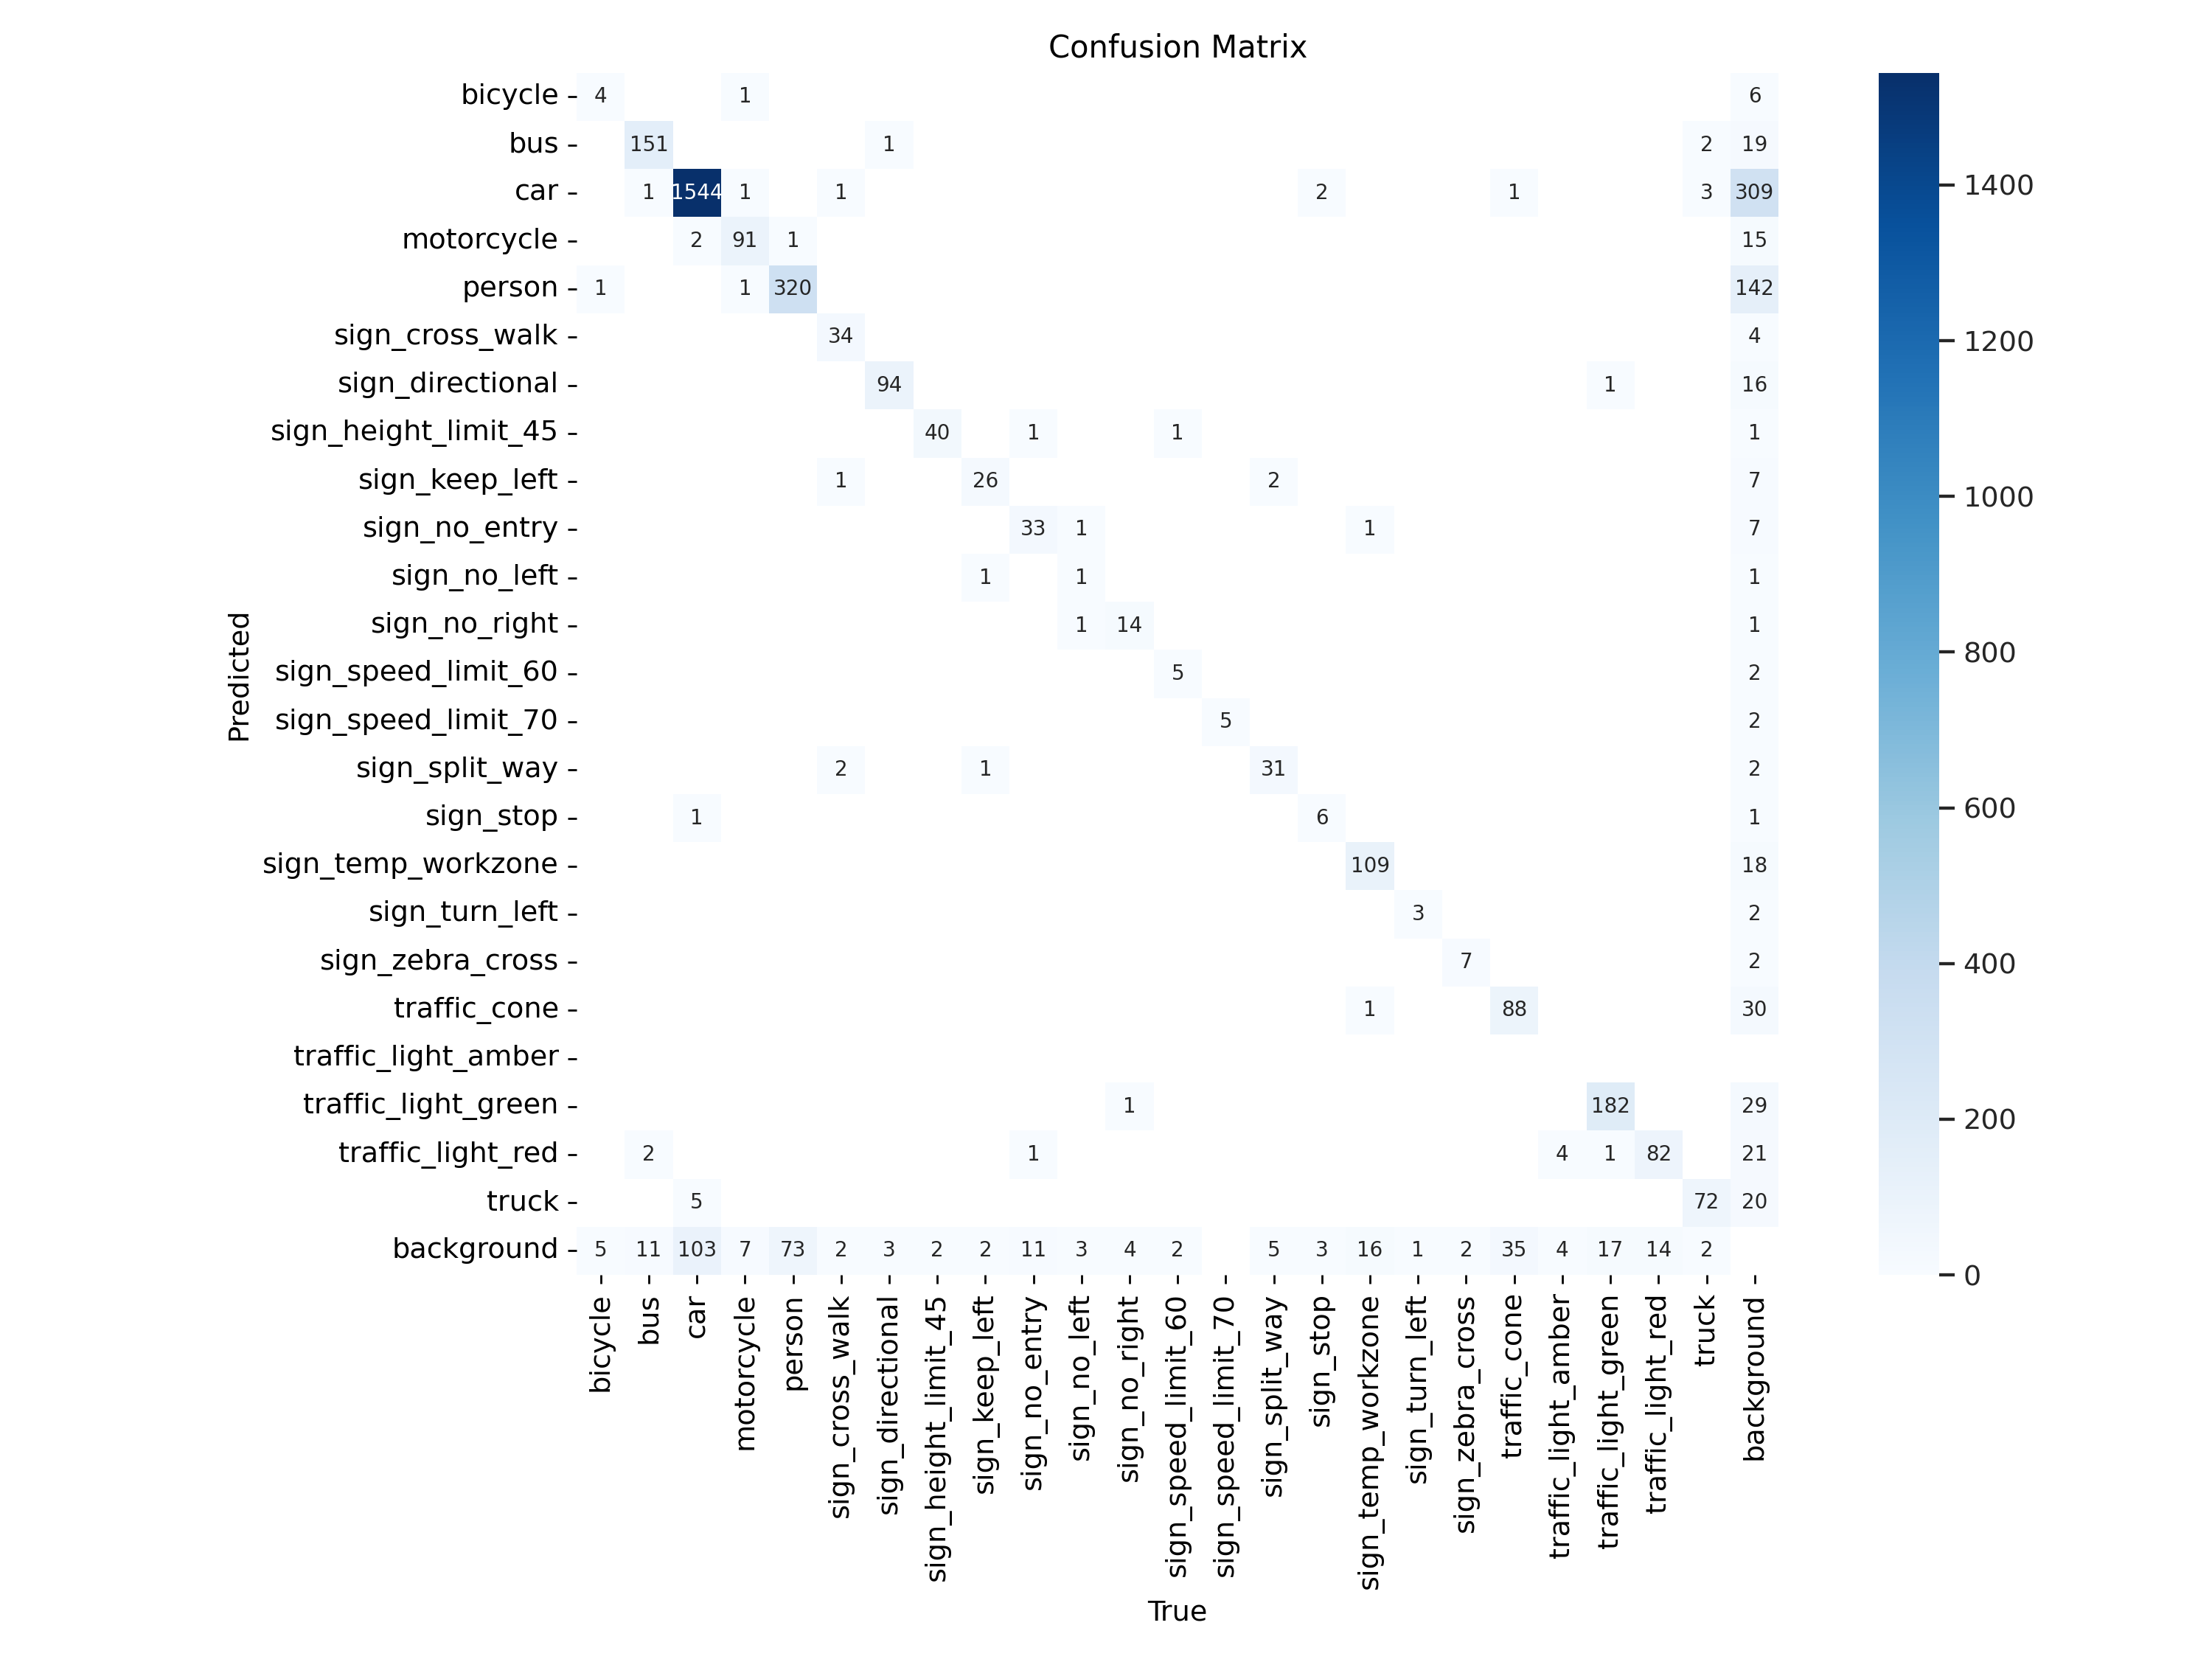

In [ ]:
Image(filename="/content/runs/detect/train/confusion_matrix.png", width=720)

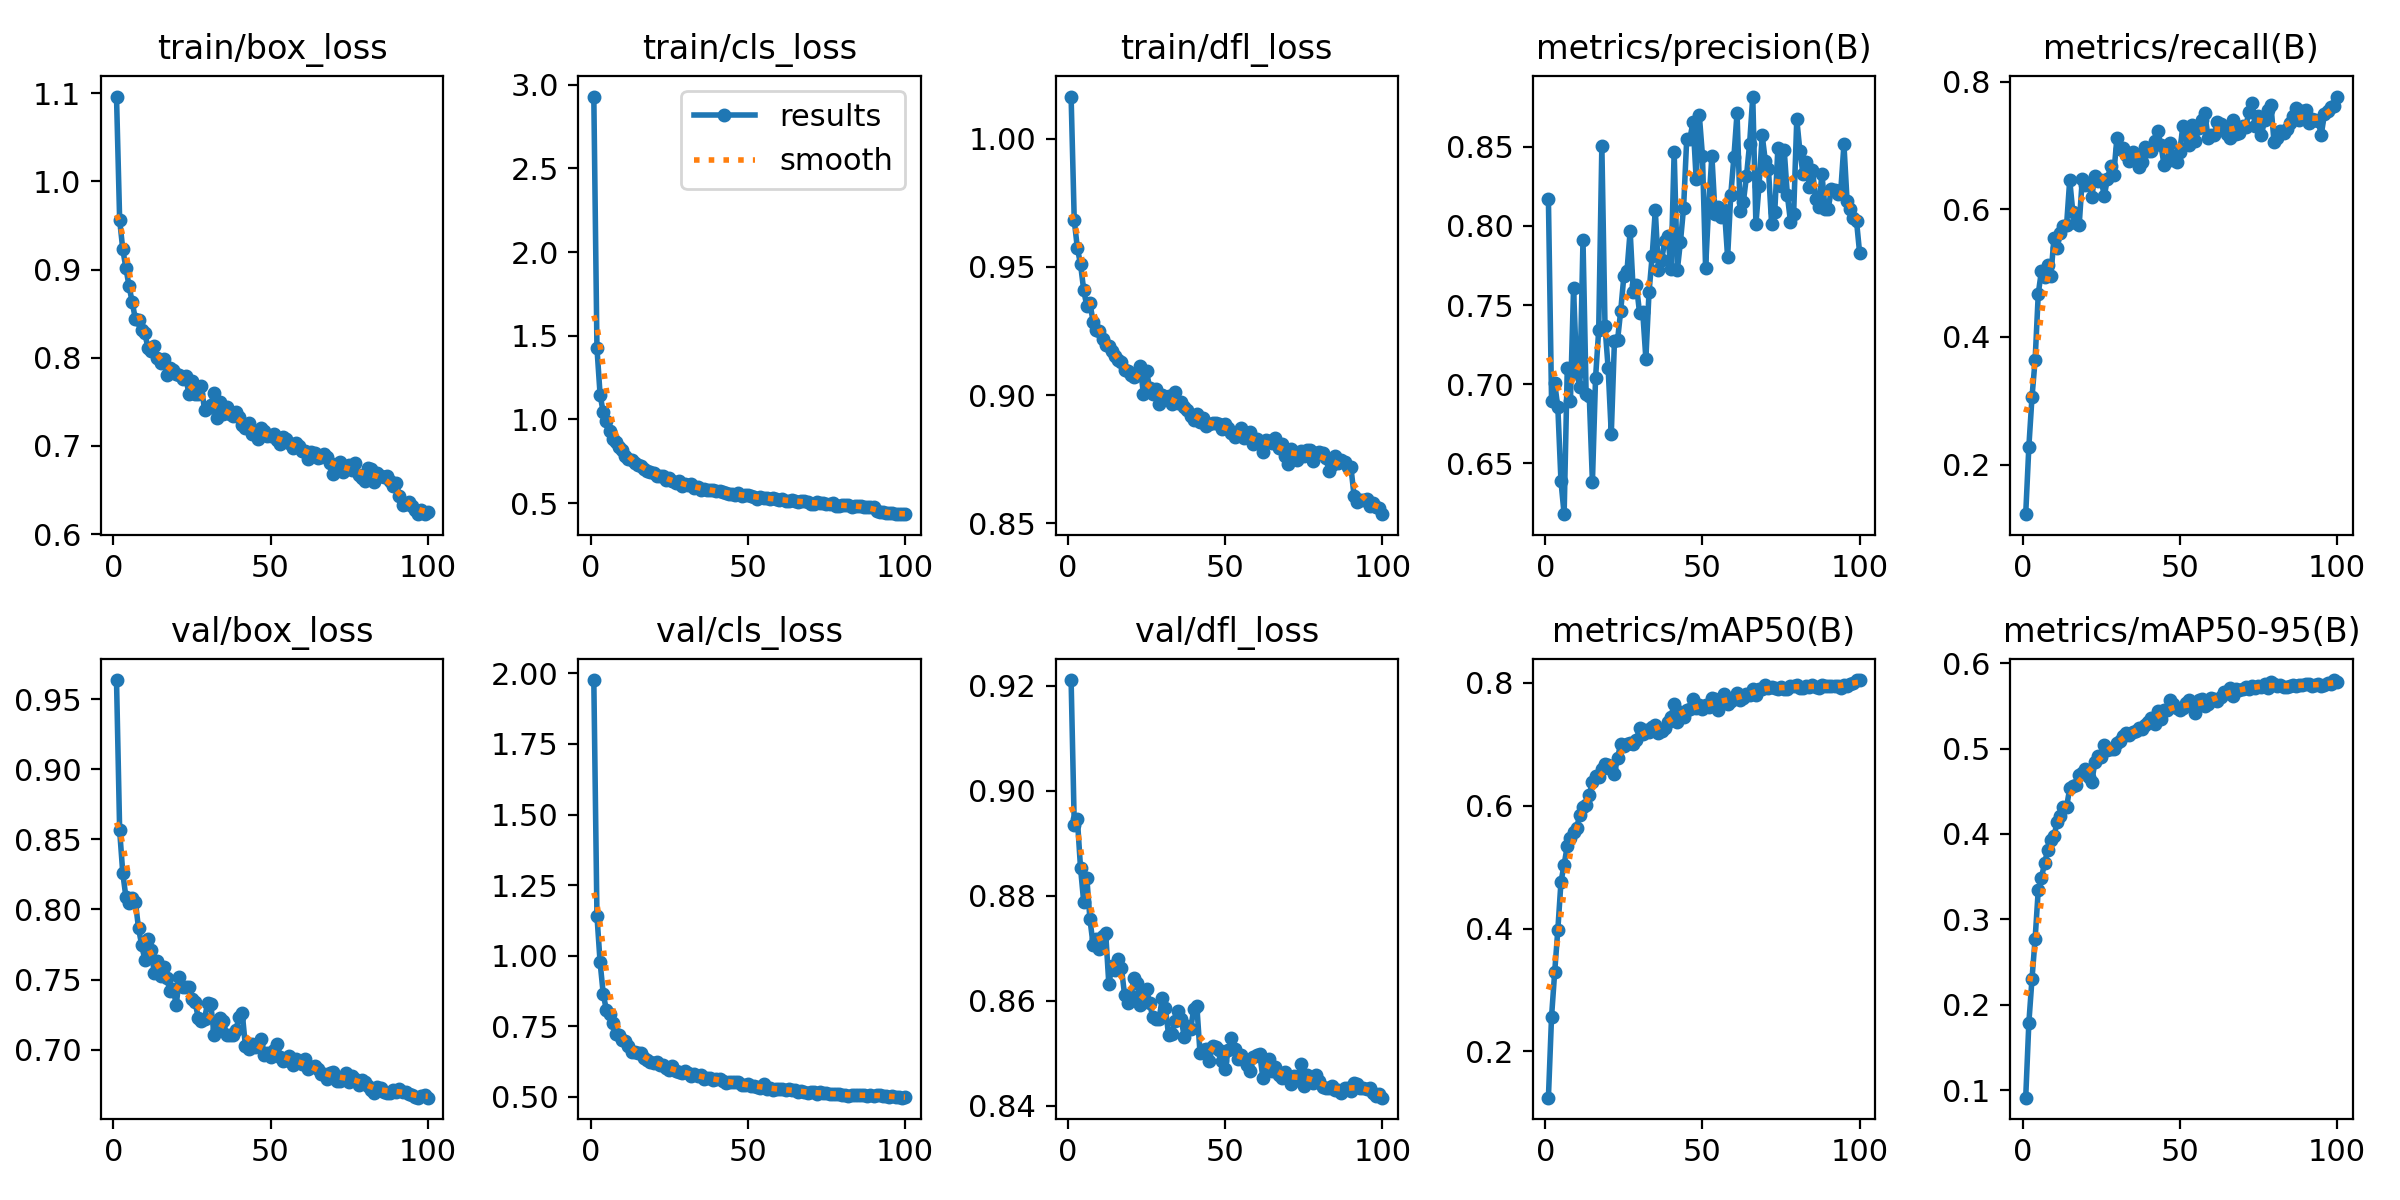

In [ ]:
Image(filename="/content/runs/detect/train/results.png", width=720)

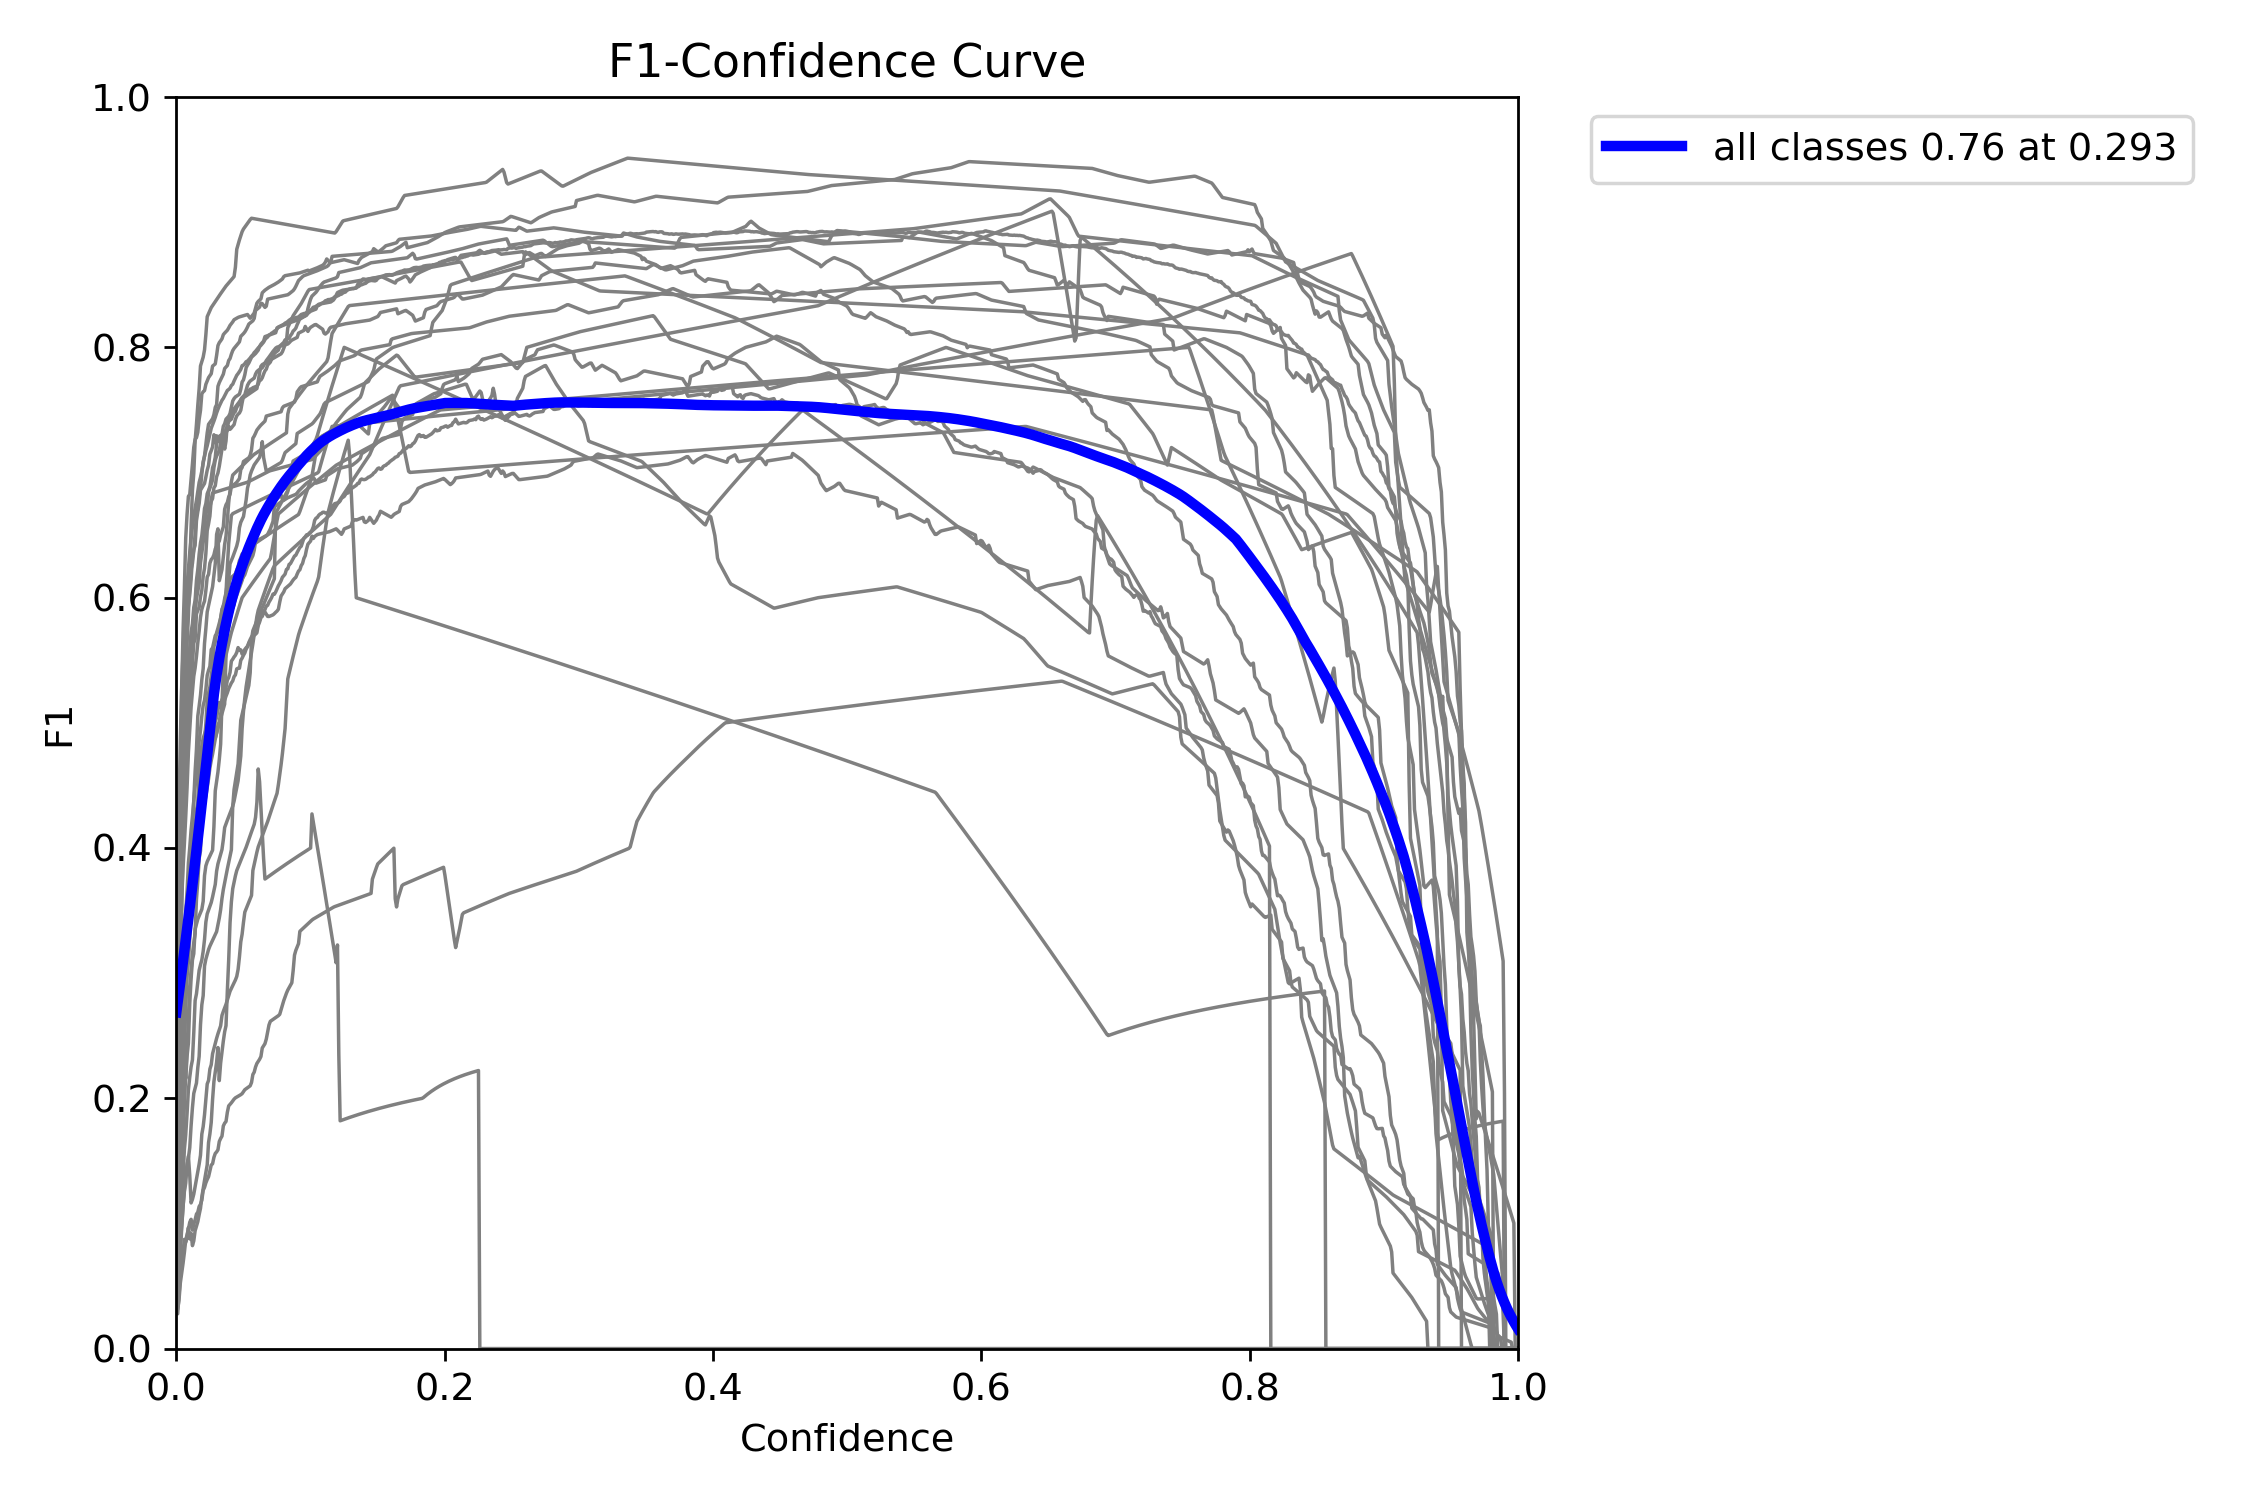

In [ ]:
Image(filename="/content/runs/detect/train/F1_curve.png", width=600)

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3010328 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/singapore_road_objects_v2-1/valid/labels.cache... 372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 372/372 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


                   all        372       3316       0.78      0.783      0.804      0.584
               bicycle        372         10      0.329        0.4      0.407      0.202
                   bus        372        165      0.873      0.917      0.929      0.834
                   car        372       1655      0.828      0.936      0.947      0.834
            motorcycle        372        101      0.845      0.931      0.932      0.693
                person        372        394      0.682      0.817      0.807      0.491
       sign_cross_walk        372         40      0.877       0.85       0.88      0.662
      sign_directional        372         98      0.842      0.969      0.961       0.78
  sign_height_limit_45        372         42      0.909      0.976      0.973      0.762
        sign_keep_left        372         30      0.718      0.867      0.807      0.576
         sign_no_entry        372         46      0.828      0.732      0.798      0.423
          sign_no_lef

---

## 4. Hyperparameter tuning

### 4.1 Model 2
Use the same YOLOv8 n size and increase imgsz to 737 and train it longer until 350 epochs.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=350 imgsz=720

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/singapore_road_objects_v2-1/data.yaml, epochs=350, time=None, patience=100, batch=16, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

#### 4.1.1. Model 2 Evaluation

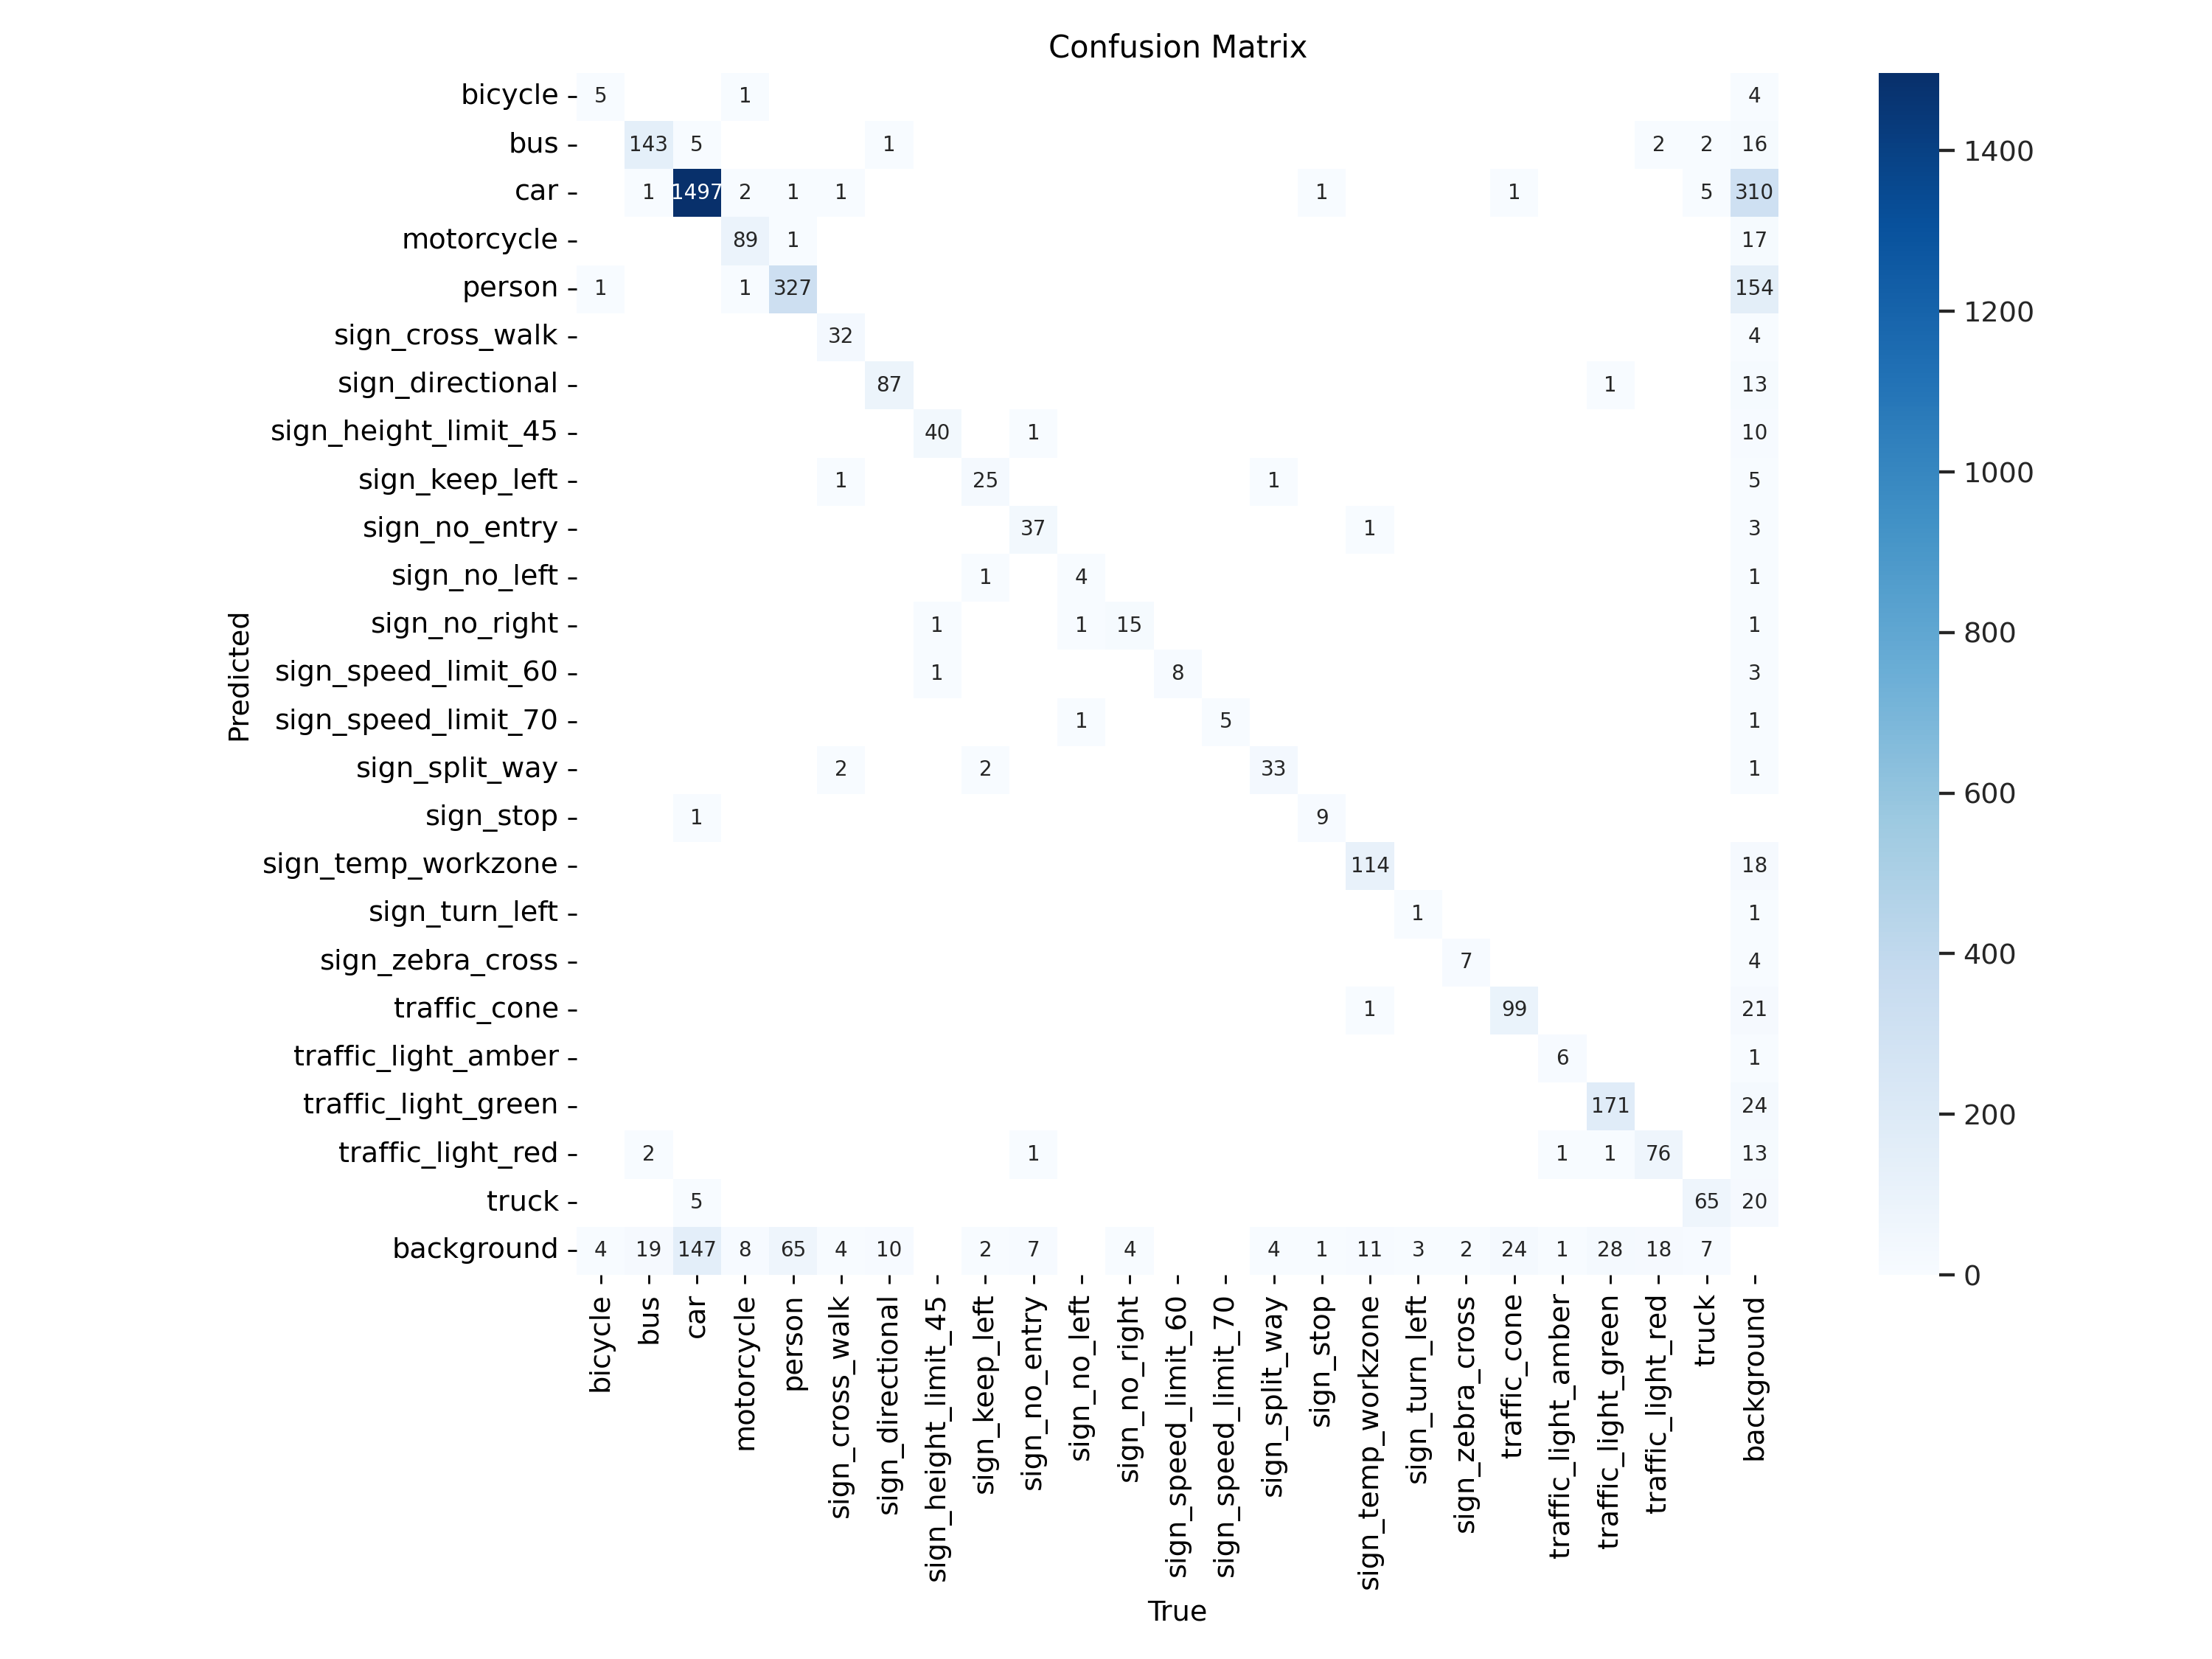

In [ ]:
Image(filename="/content/runs/detect/train2/confusion_matrix.png", width=720)

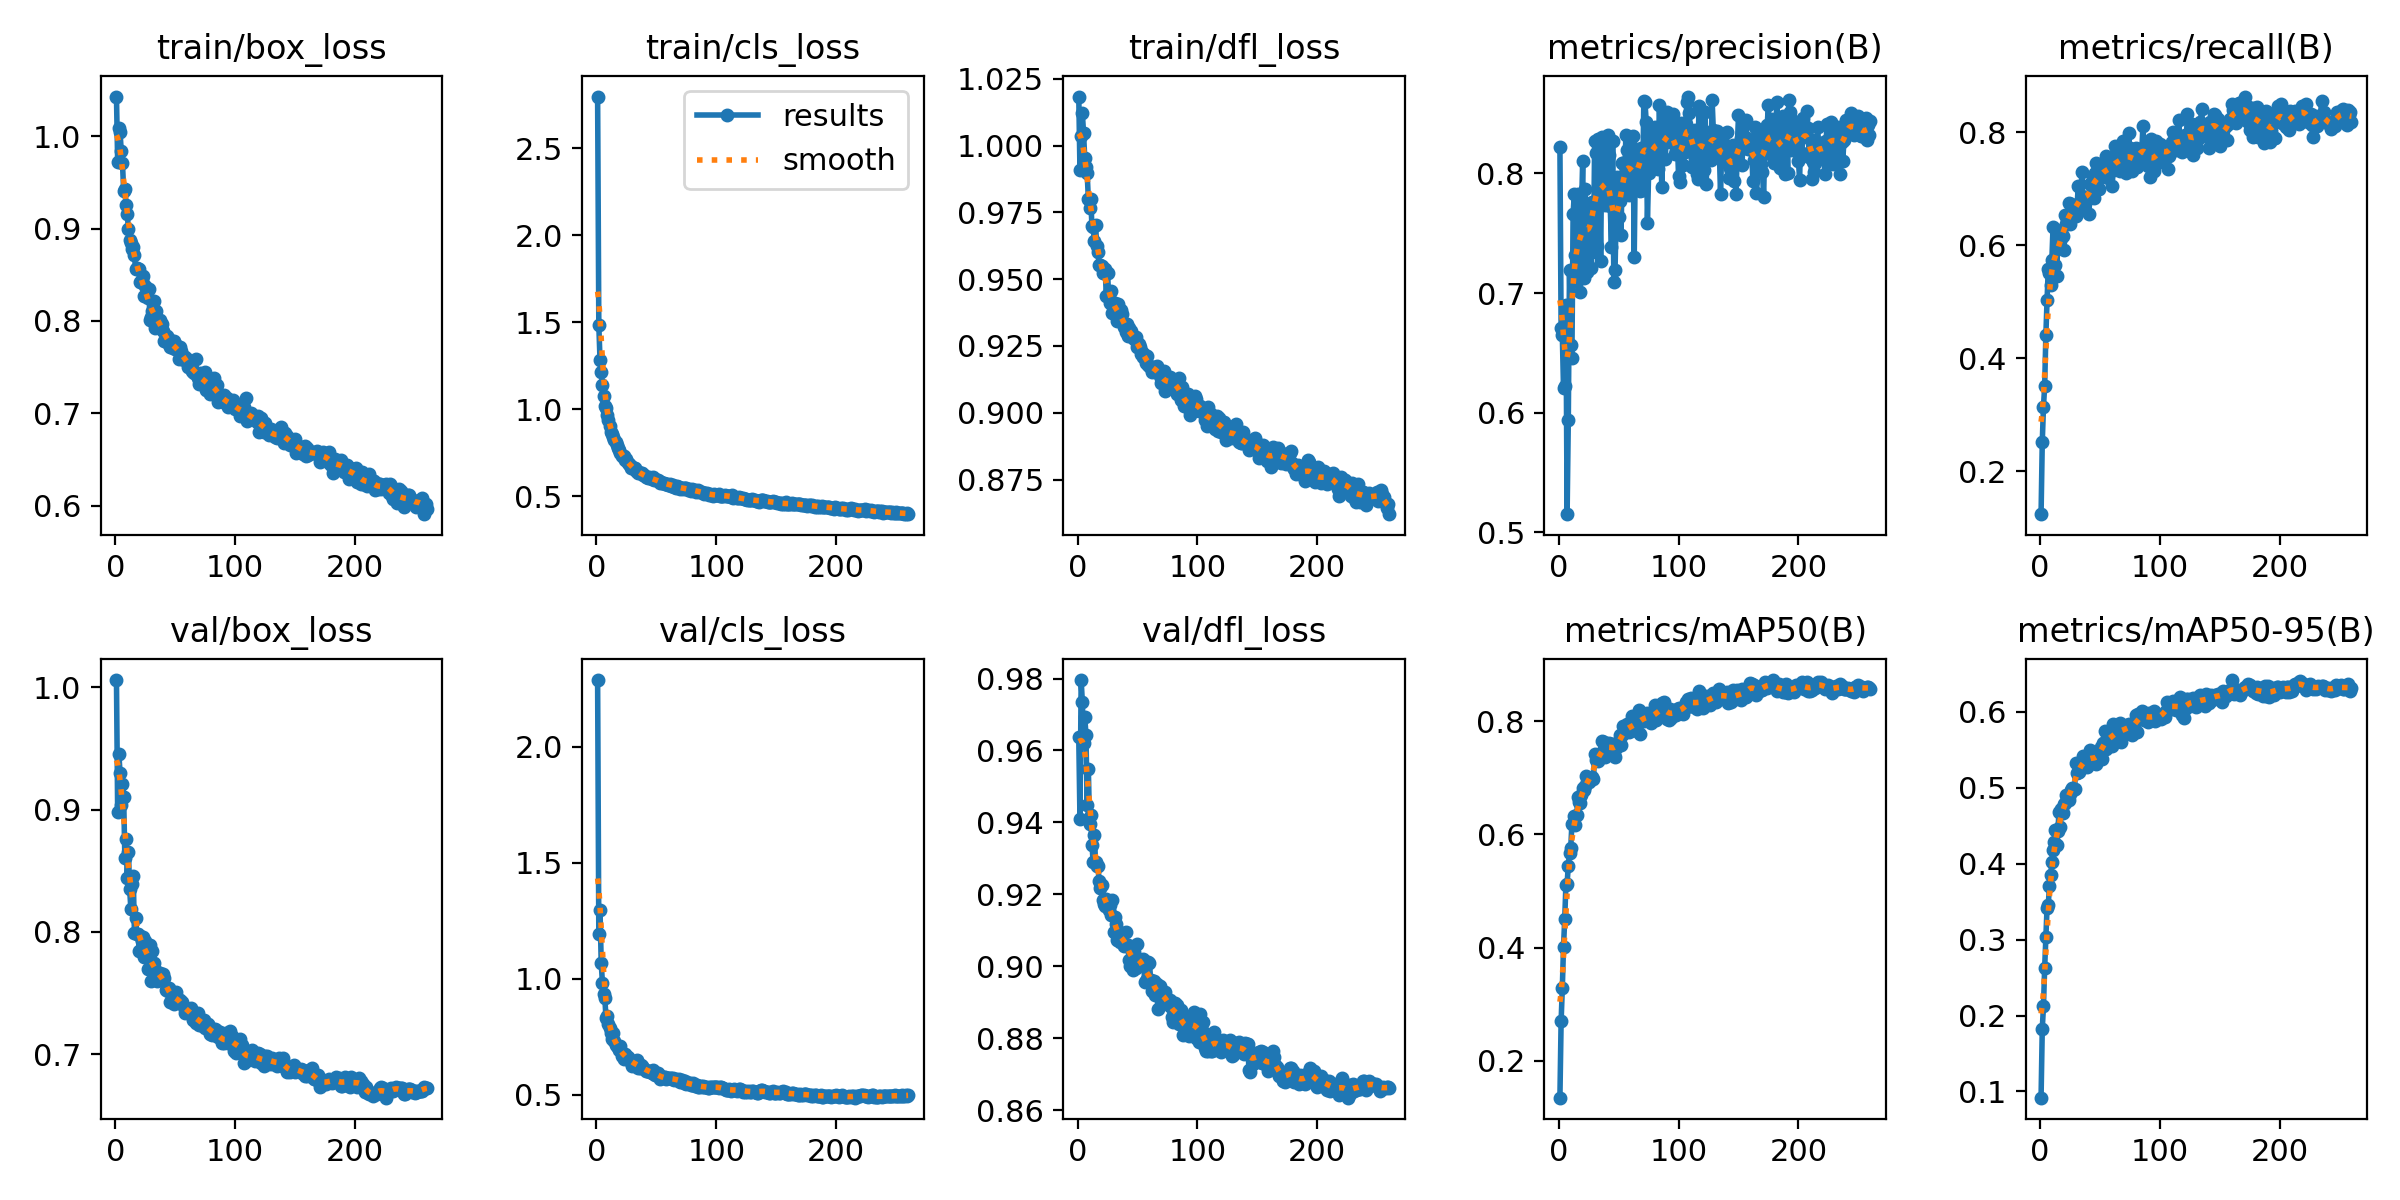

In [ ]:
Image(filename="/content/runs/detect/train2/results.png", width=720)

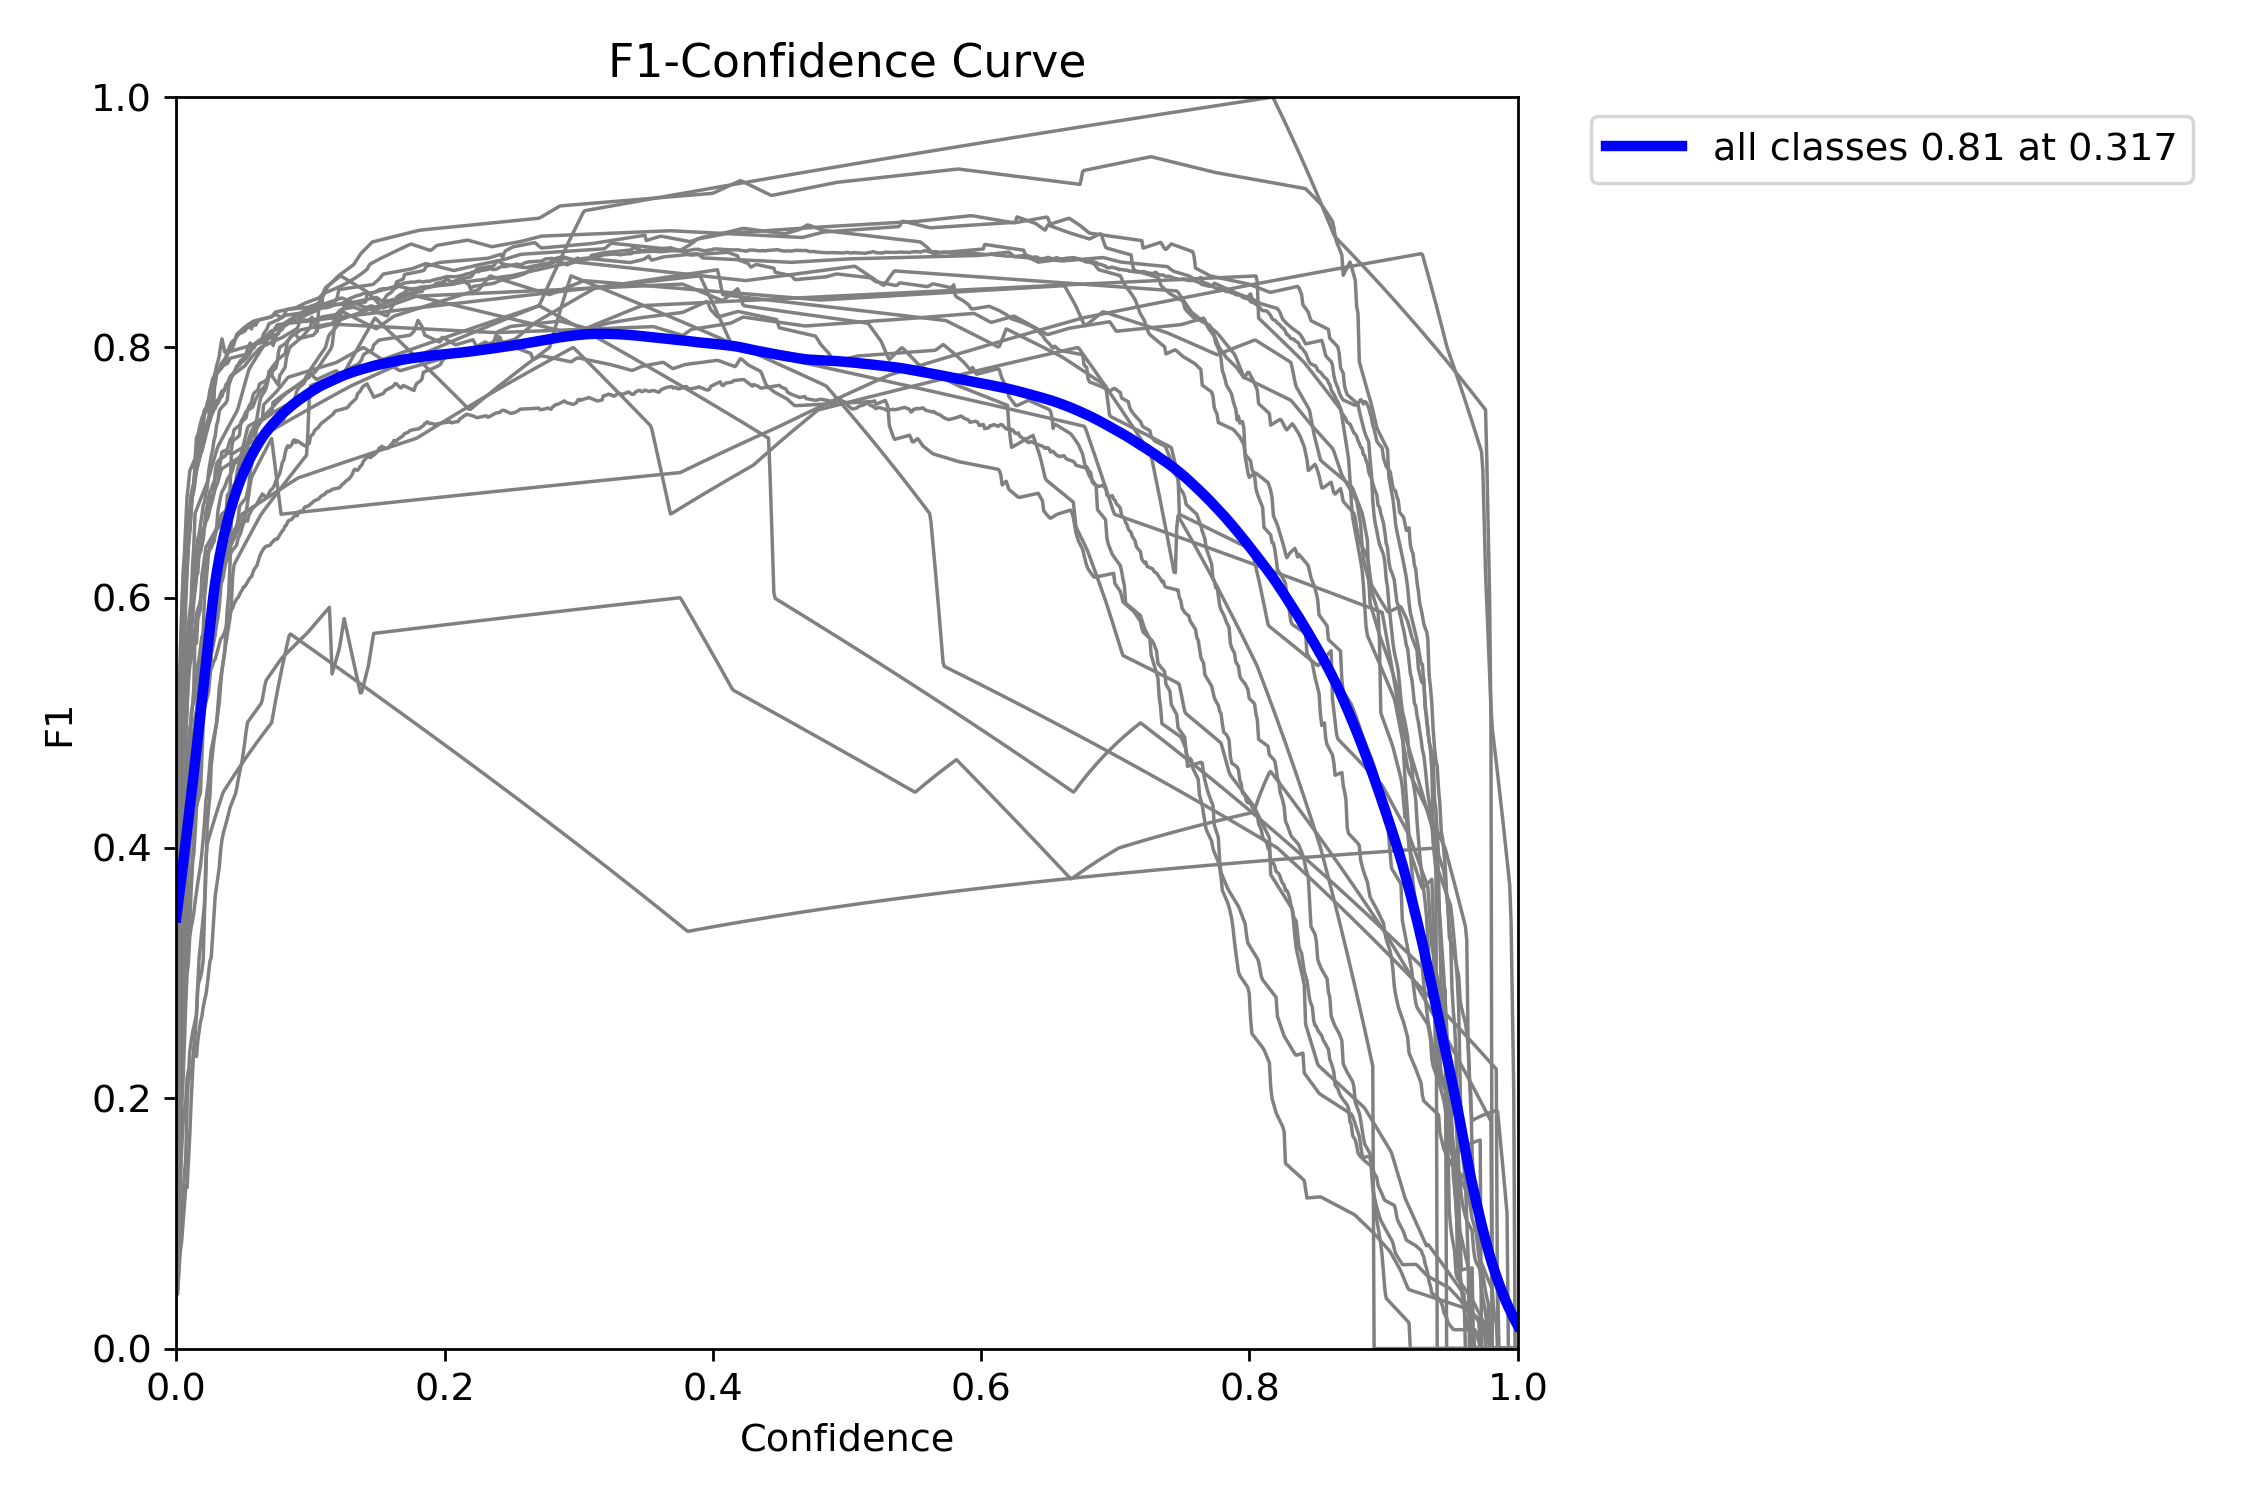

In [ ]:
Image(filename="/content/runs/detect/train2/F1_curve.png", width=600)

In [ ]:
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # load a custom model

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3010328 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/singapore_road_objects_v2-1/valid/labels.cache... 372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 372/372 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


                   all        372       3316      0.826      0.849      0.868      0.645
               bicycle        372         10      0.564        0.6      0.592      0.245
                   bus        372        165      0.882       0.91      0.948      0.851
                   car        372       1655      0.851      0.933      0.951      0.845
            motorcycle        372        101      0.874      0.921       0.93       0.71
                person        372        394      0.723      0.802      0.811      0.503
       sign_cross_walk        372         40      0.916      0.821      0.871      0.648
      sign_directional        372         98      0.871      0.967      0.968      0.819
  sign_height_limit_45        372         42      0.847          1      0.971      0.787
        sign_keep_left        372         30      0.874      0.867      0.831      0.605
         sign_no_entry        372         46      0.903      0.848      0.893      0.527
          sign_no_lef

---

### 4.2. Model 3
Use the same YOLOv8 n size and increase imgsz to 704 and train it longer until 200 epochs.  
Still using AdamW optimizer but adjust the learning rate to 0.001, momentum 0.95, and weight decay 0.0001.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml batch=32 epochs=200 imgsz=704 optimizer=AdamW lr0=0.001 lrf=0.001 momentum=0.95 weight_decay=0.0001 warmup_epochs=5 warmup_momentum=0.5 warmup_bias_lr=0.1

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/singapore_road_objects_v2-1/data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=704, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

#### 4.2.1 Model 3 Evaluation

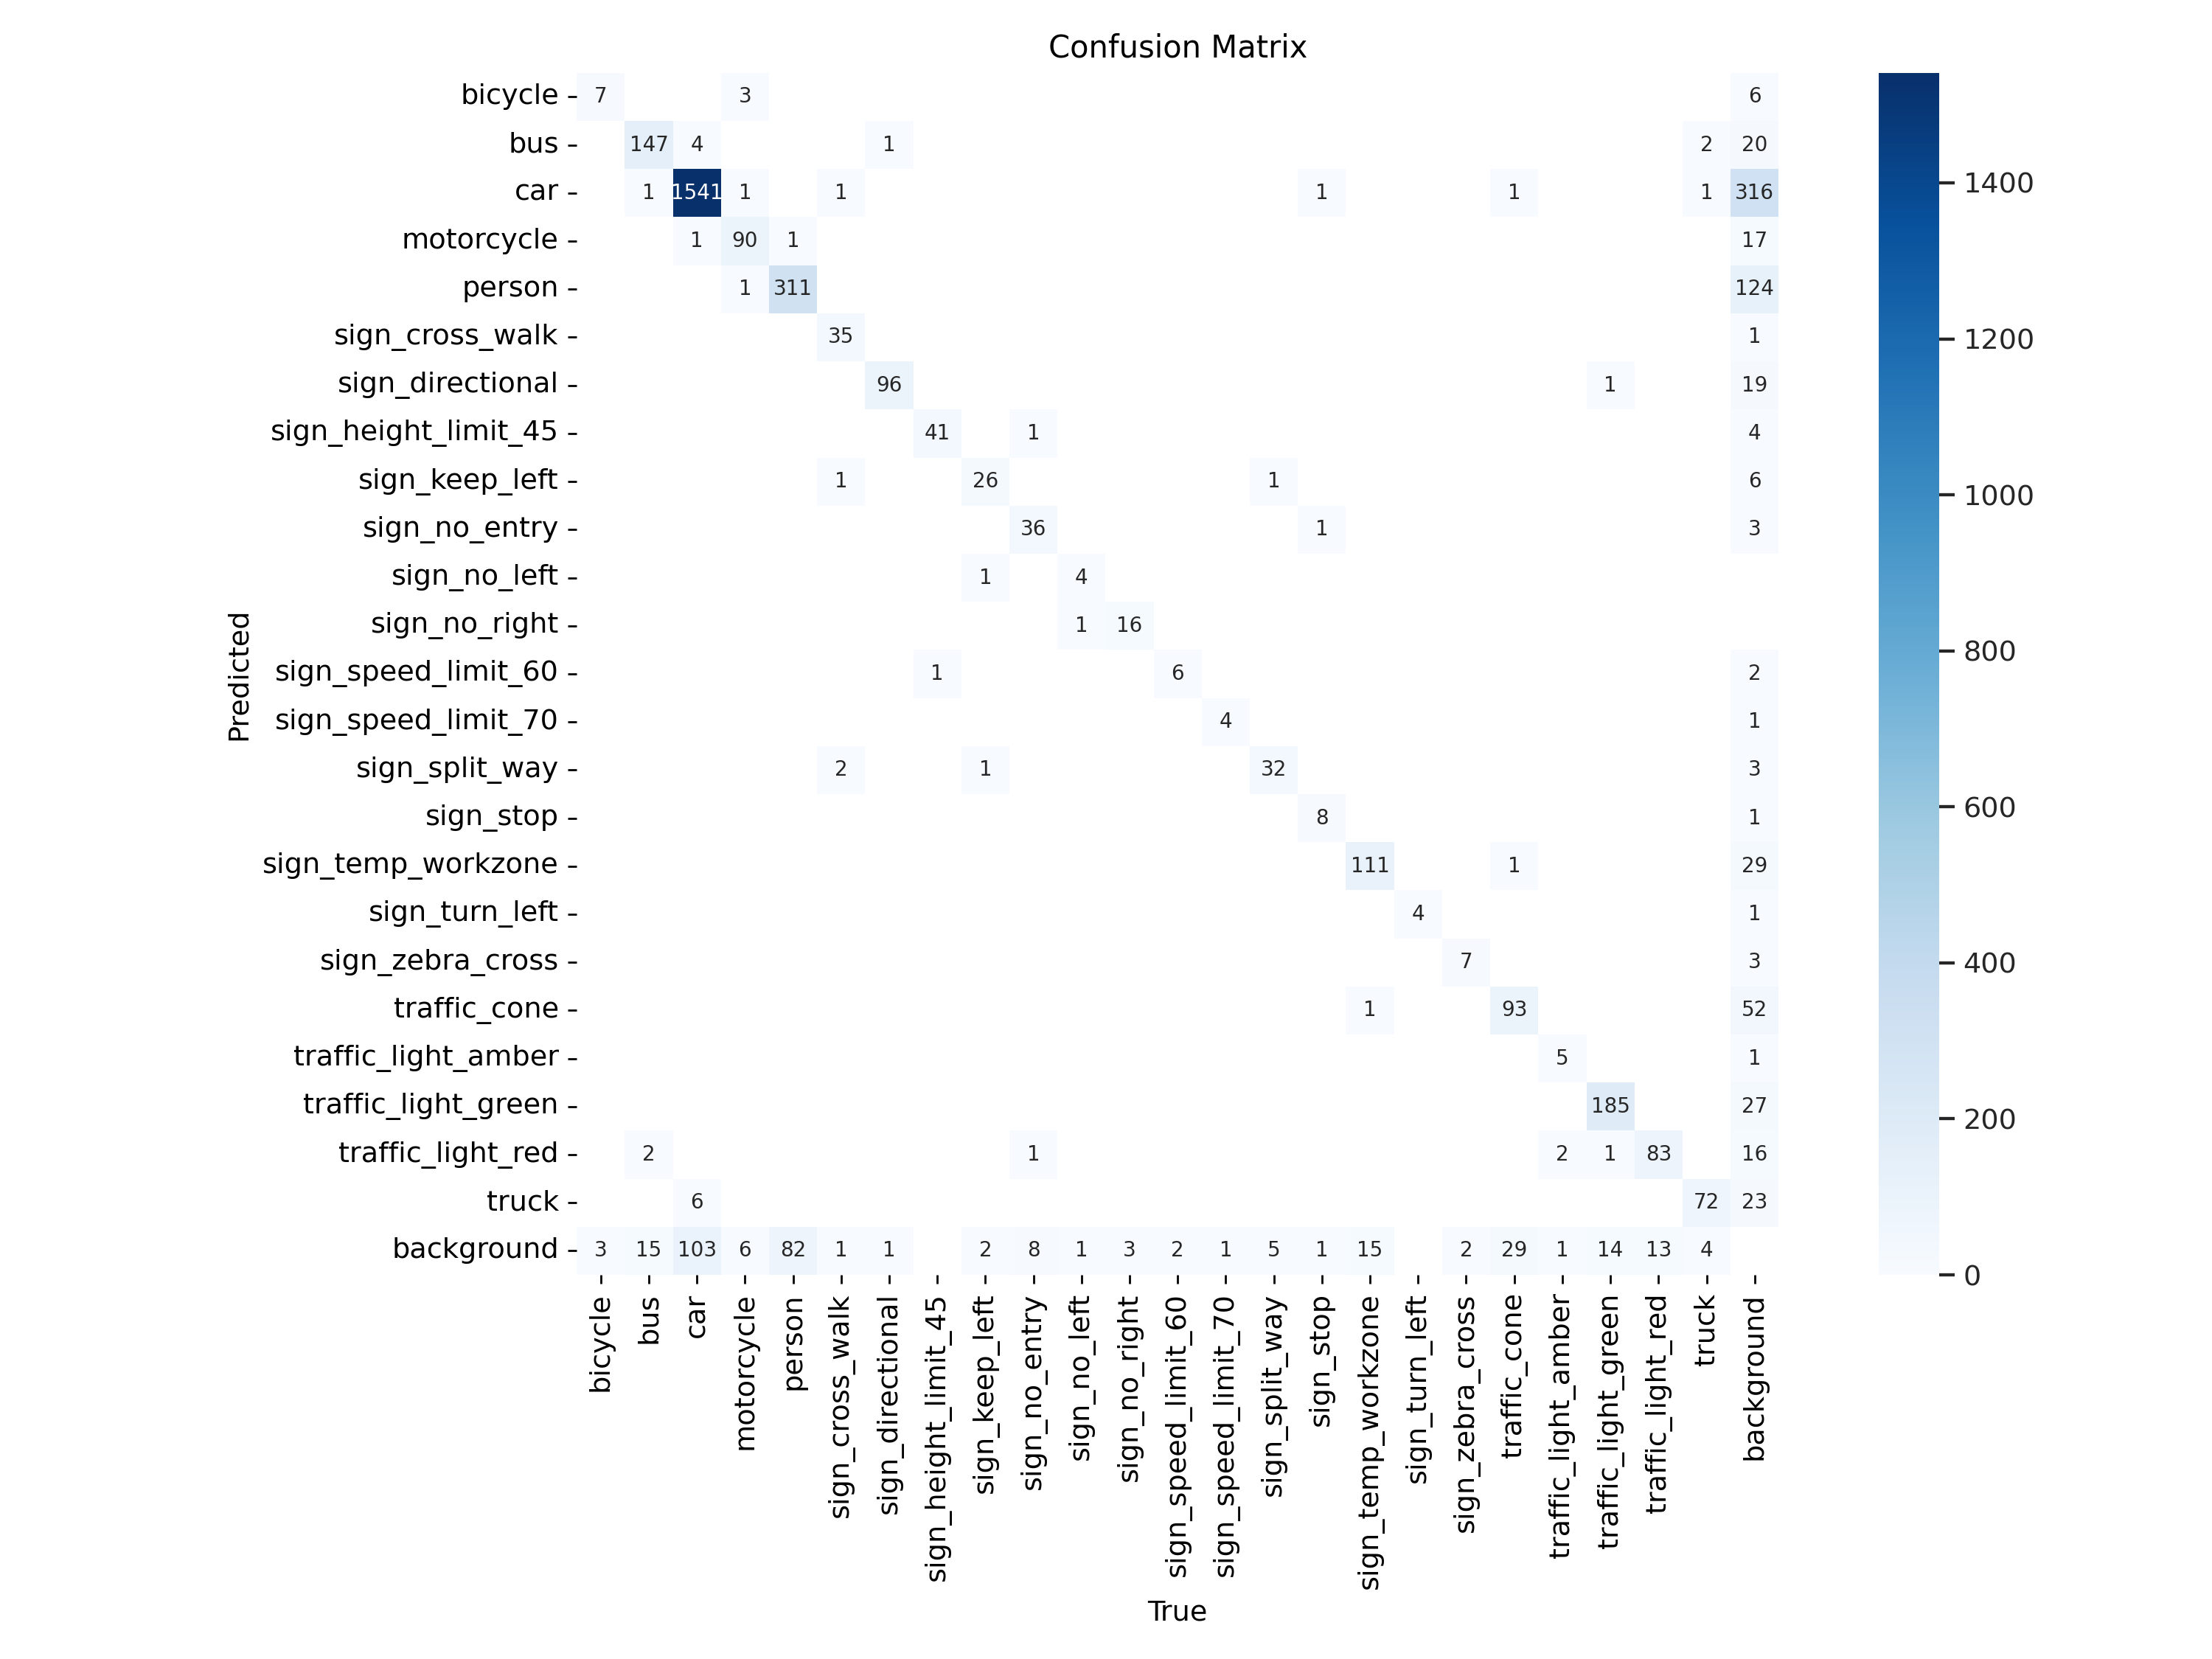

In [ ]:
Image(filename="/content/runs/detect/train/confusion_matrix.png", width=720)

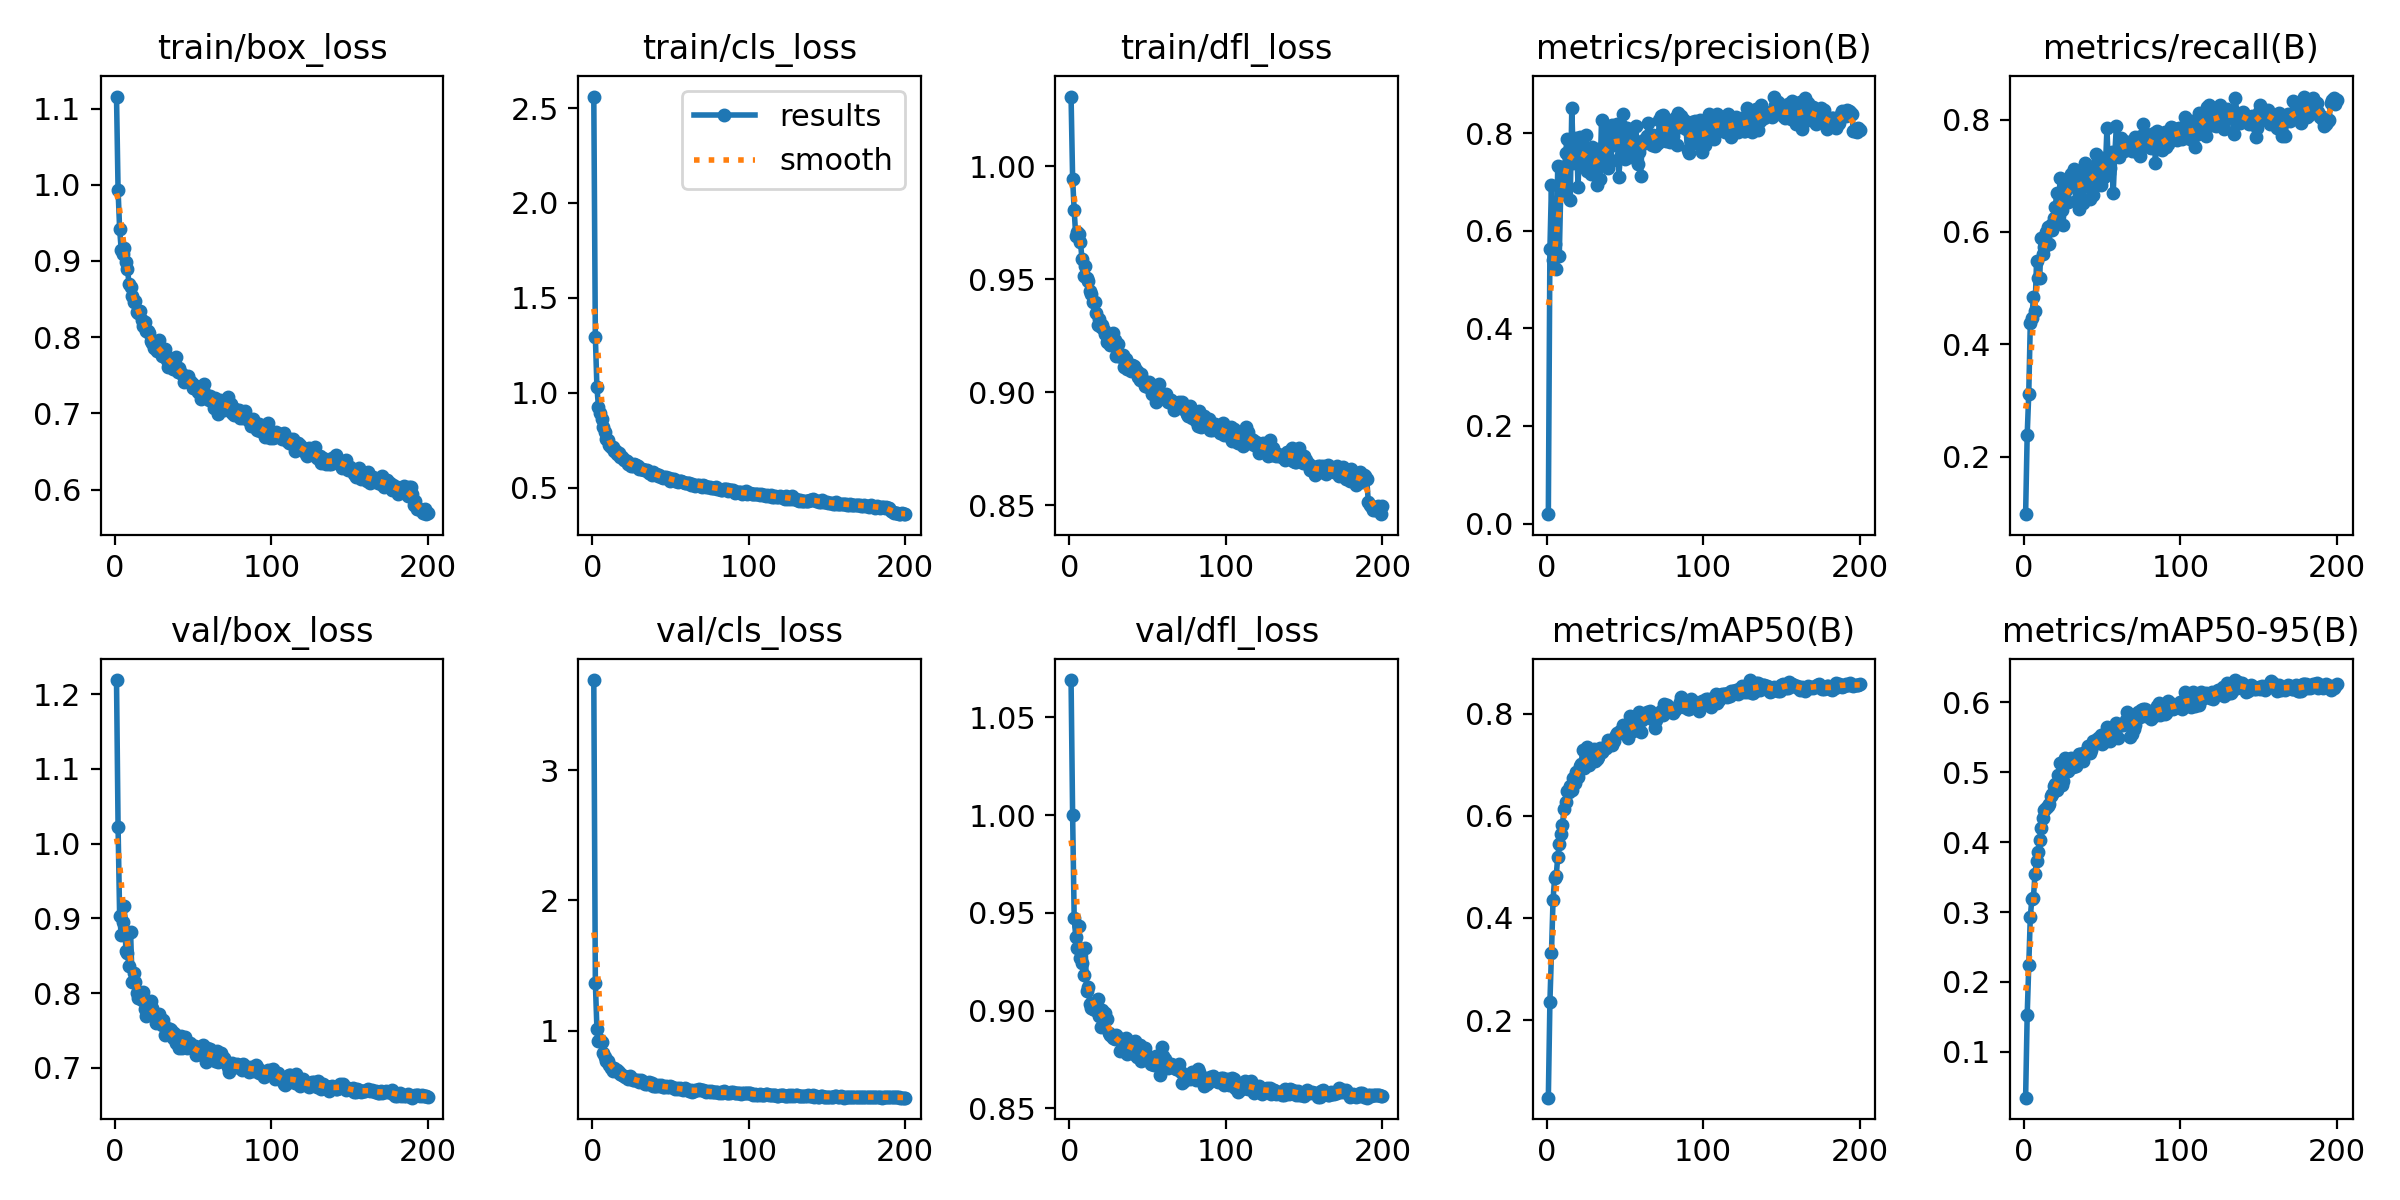

In [ ]:
Image(filename="/content/runs/detect/train/results.png", width=720)

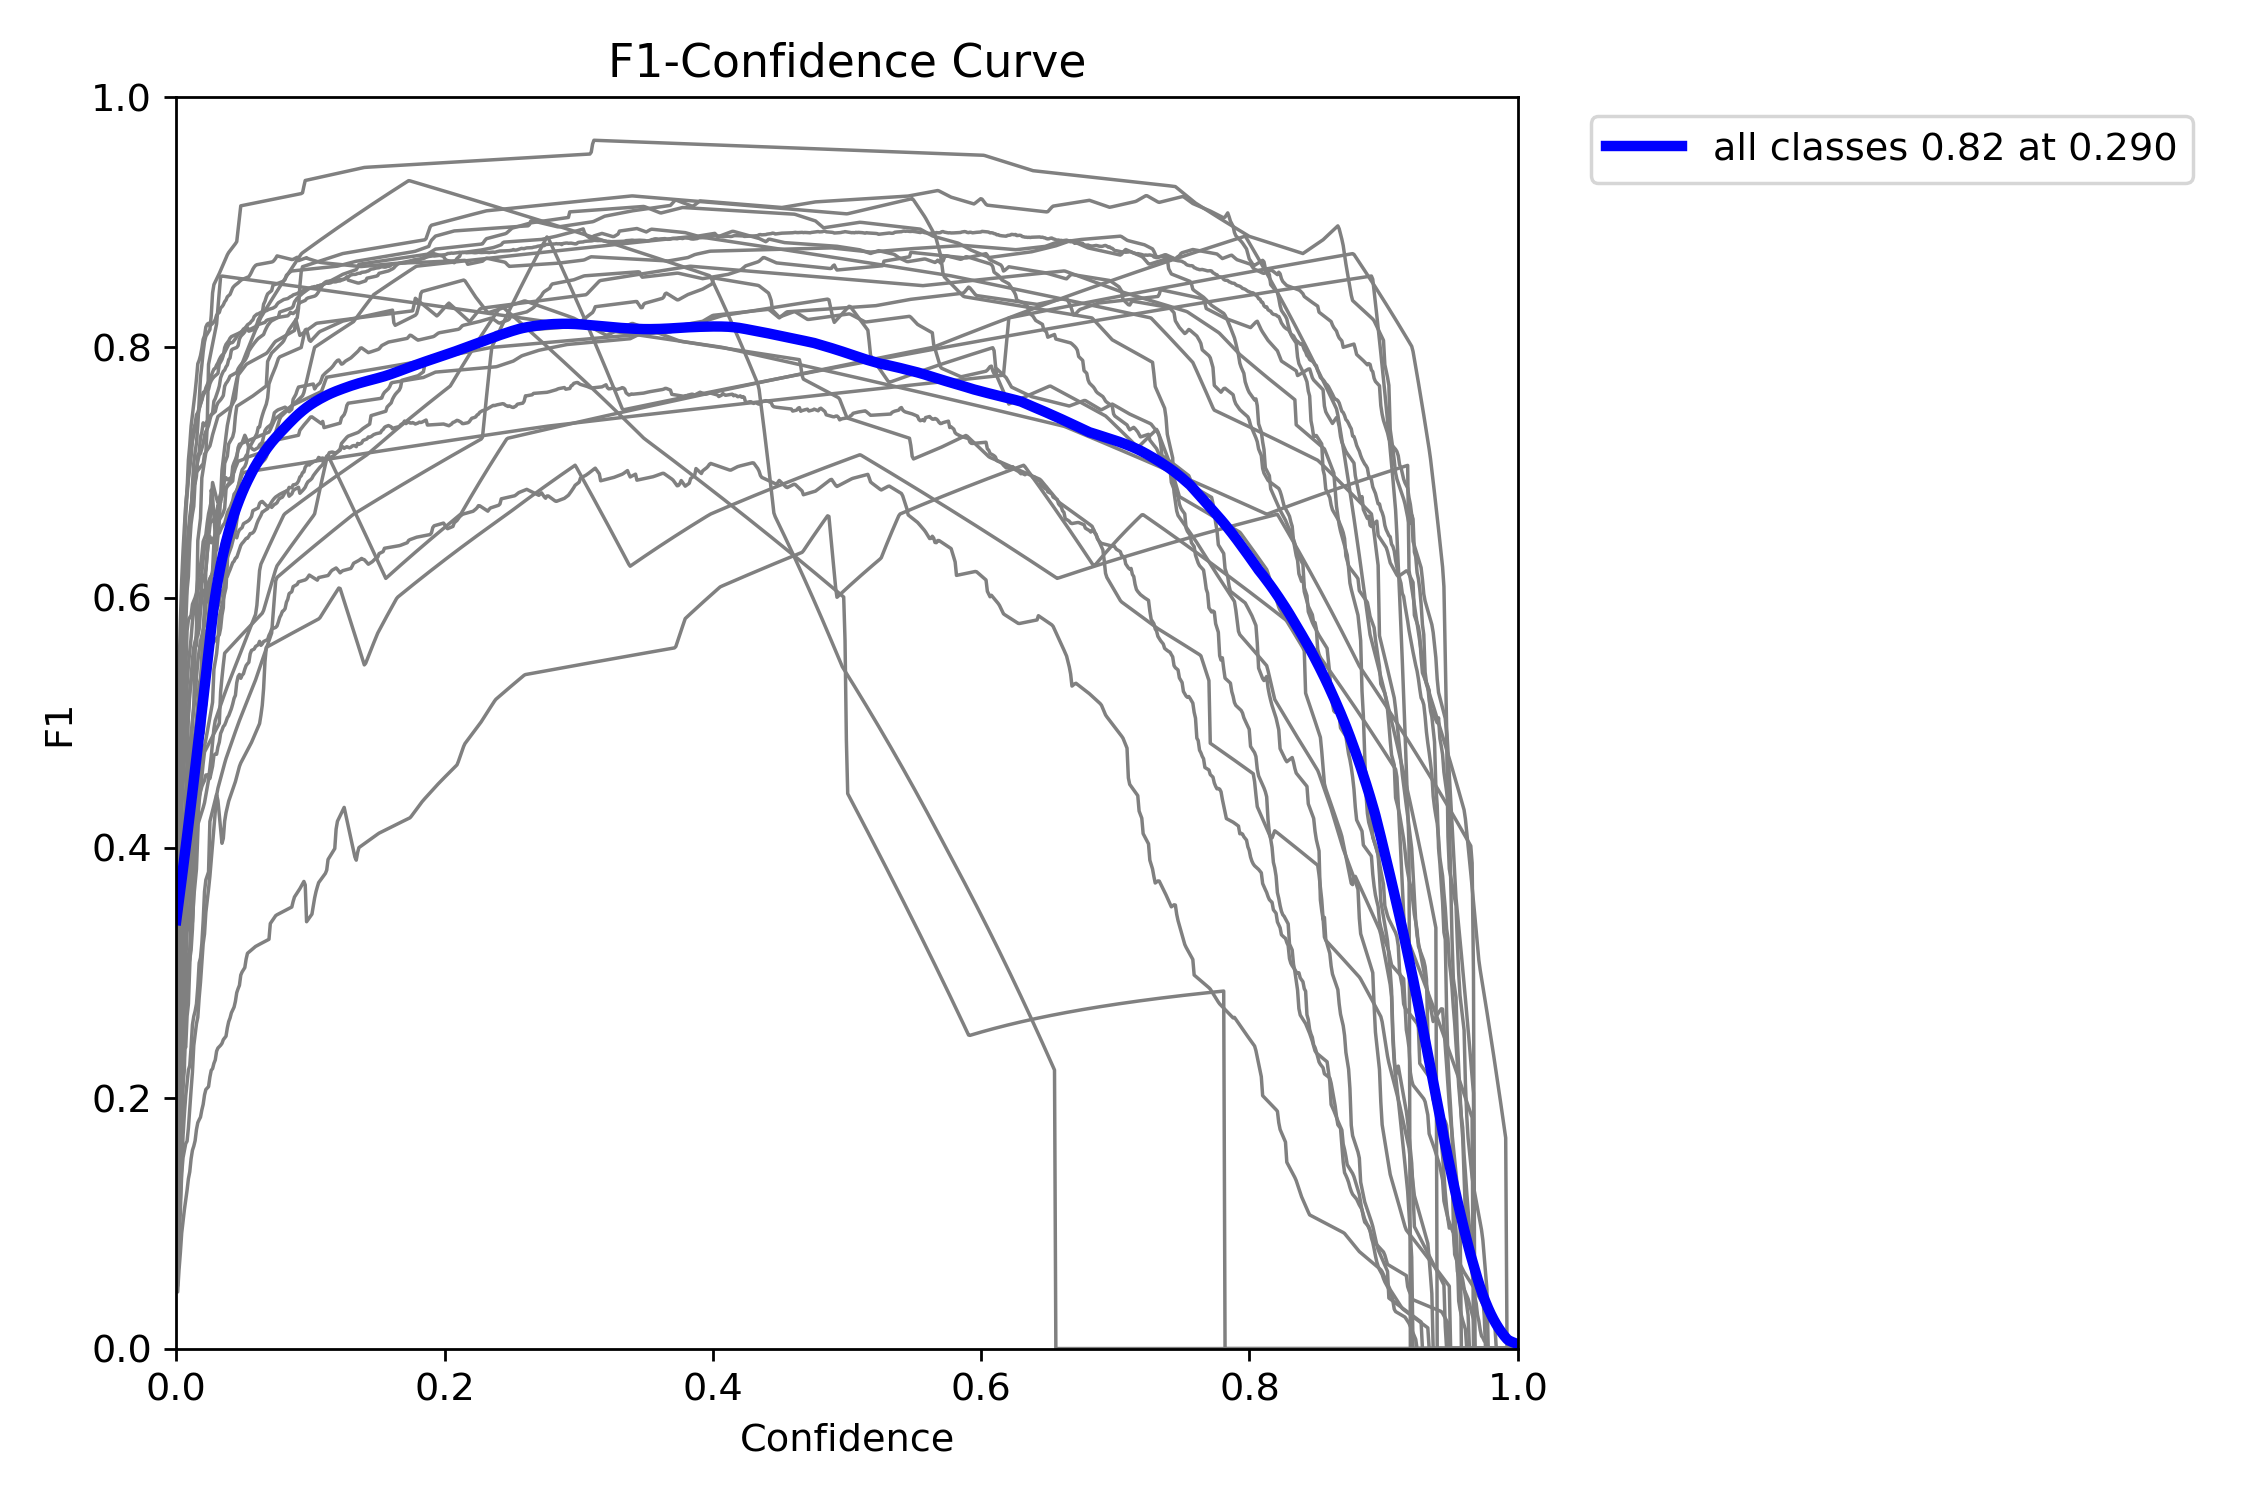

In [ ]:
Image(filename="/content/runs/detect/train/F1_curve.png", width=600)

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3010328 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/singapore_road_objects_v2-1/valid/labels.cache... 372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 372/372 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


                   all        372       3316      0.807      0.839      0.861      0.633
               bicycle        372         10      0.448        0.7      0.701      0.378
                   bus        372        165      0.849      0.891      0.934      0.854
                   car        372       1655      0.847      0.924      0.946      0.844
            motorcycle        372        101      0.888      0.931      0.924      0.697
                person        372        394      0.757      0.784      0.821      0.507
       sign_cross_walk        372         40      0.963      0.875      0.882      0.653
      sign_directional        372         98      0.838      0.969      0.957      0.799
  sign_height_limit_45        372         42      0.912          1      0.975      0.773
        sign_keep_left        372         30      0.754      0.867      0.836      0.634
         sign_no_entry        372         46      0.897      0.756       0.87      0.529
          sign_no_lef

---

### 4.3 Model 4
Use the same YOLOv8 n size but change the optimizer to SGD, also increase imgsz to 704 and train it longer until 200 epochs.  
Adjust the learning rate to 0.001, momentum 0.95, and weight decay 0.0001.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml batch=32 epochs=200 imgsz=704 optimizer=SGD lr0=0.01 lrf=0.01 momentum=0.95 weight_decay=0.0001 warmup_epochs=10 warmup_momentum=0.5 warmup_bias_lr=0.1

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/singapore_road_objects_v2-1/data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=704, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

#### Model 4 Evaluation

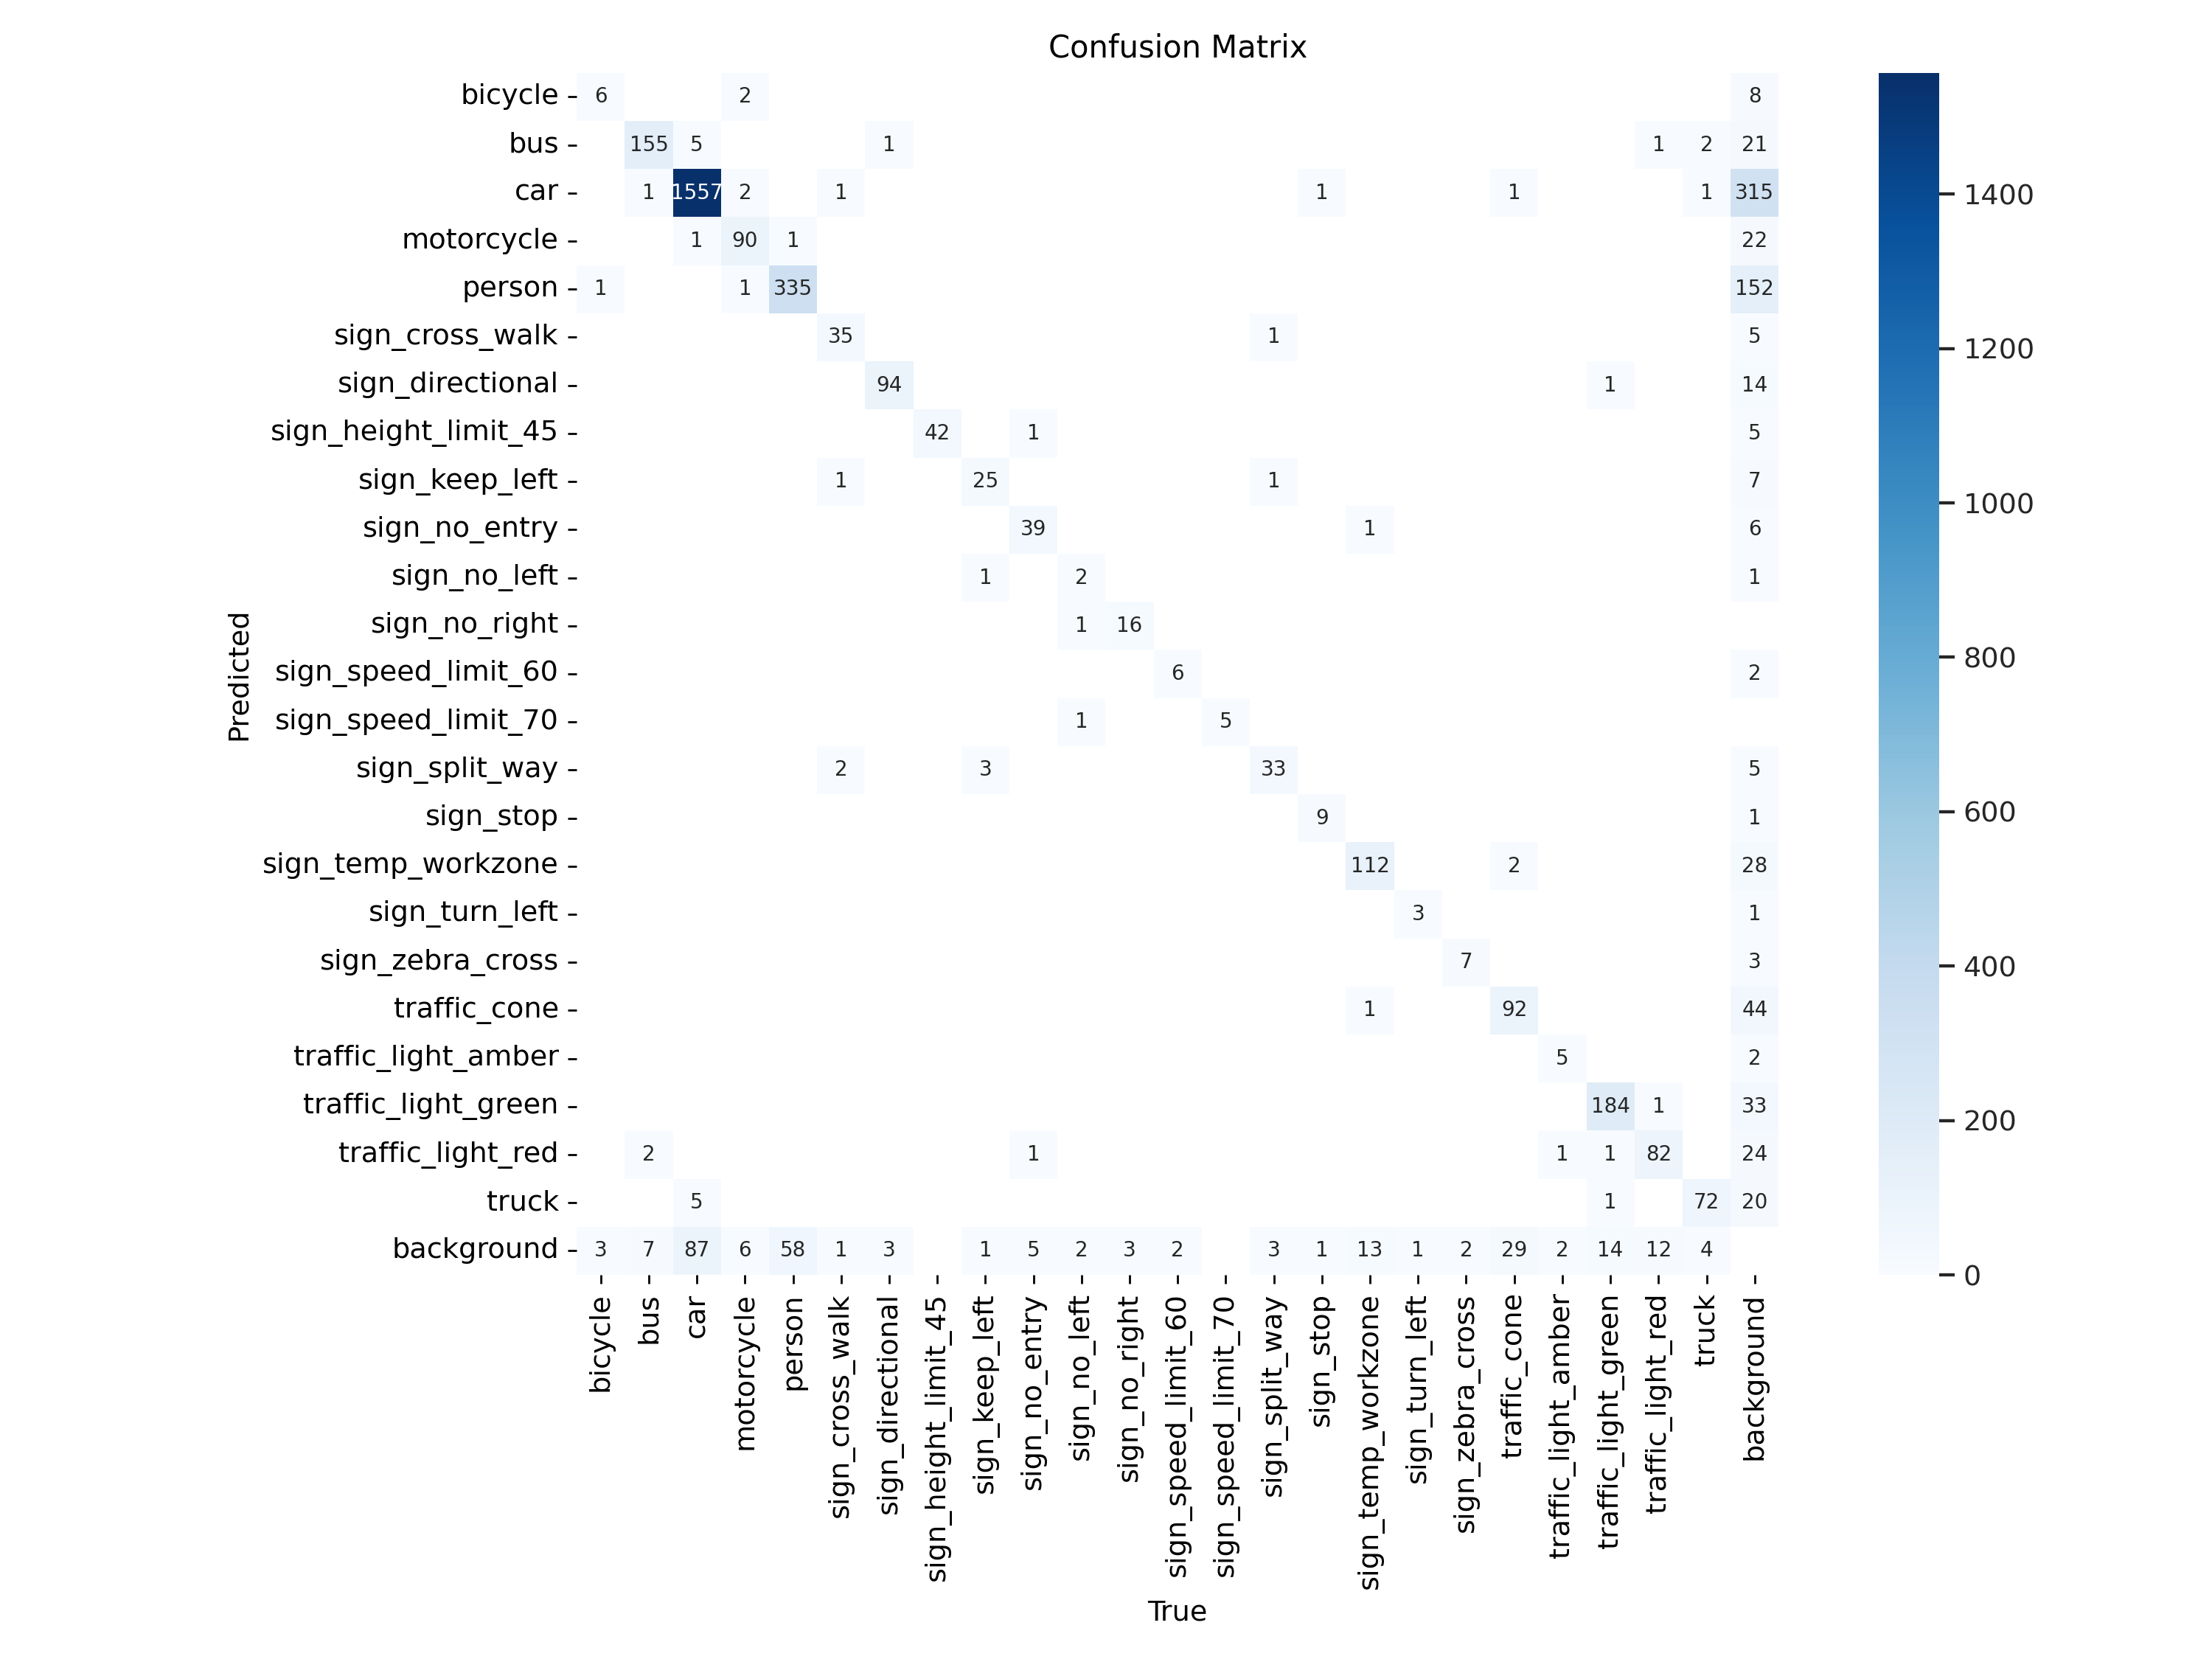

In [ ]:
Image(filename="/content/runs/detect/train/confusion_matrix.png", width=720)

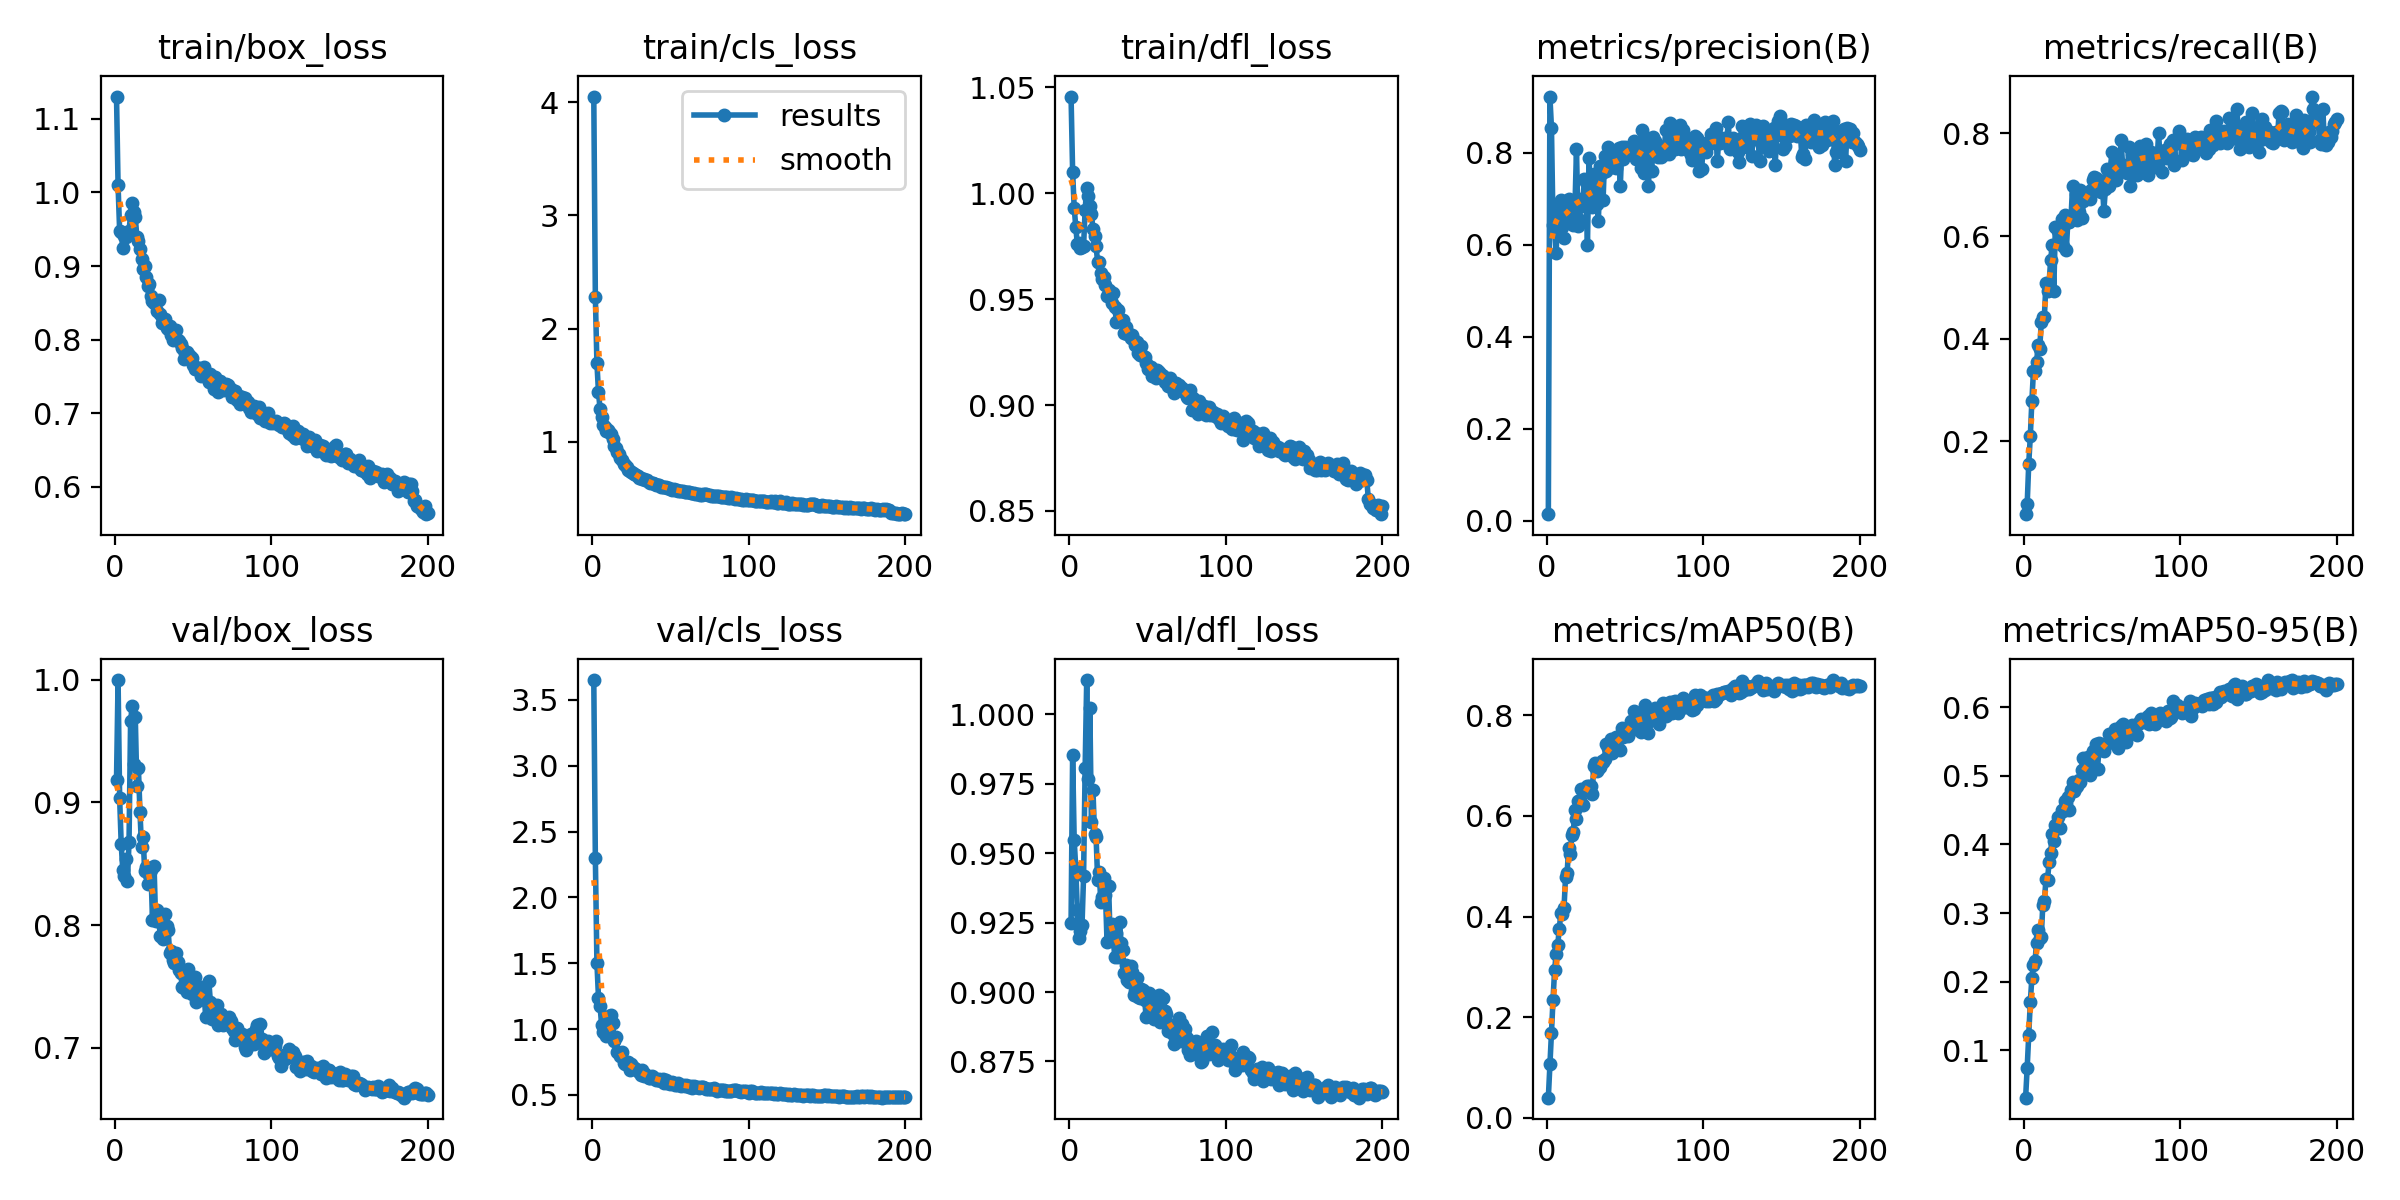

In [ ]:
Image(filename="/content/runs/detect/train/results.png", width=720)

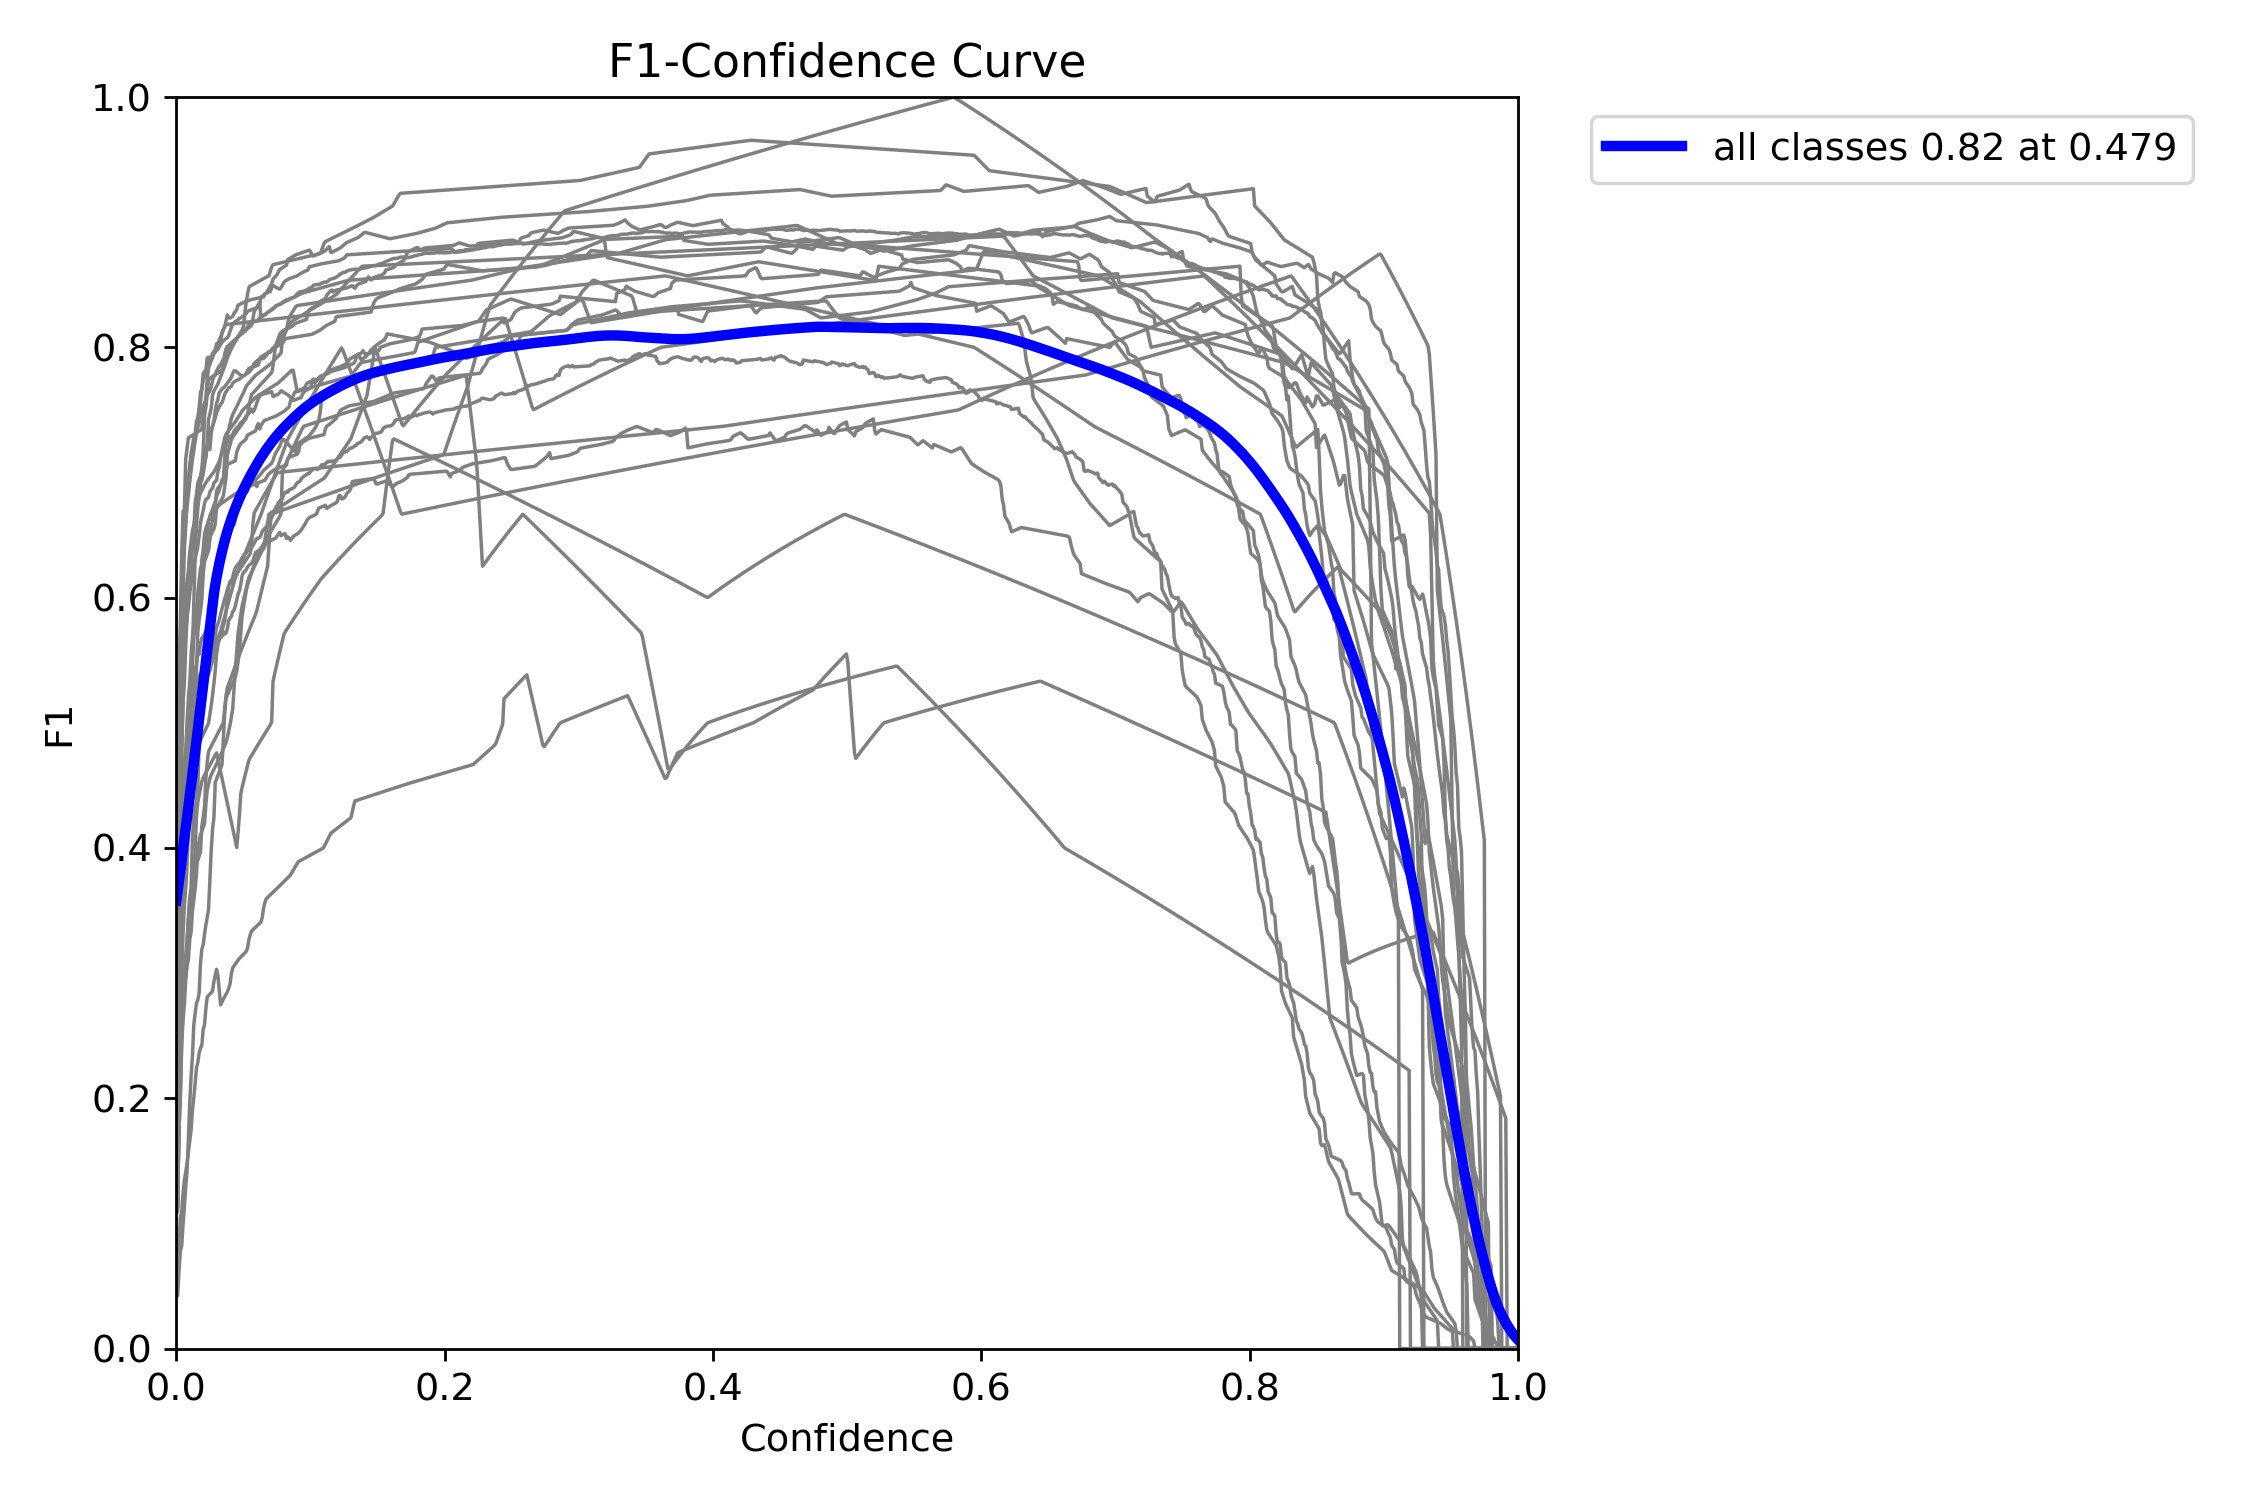

In [ ]:
Image(filename="/content/runs/detect/train/F1_curve.png", width=600)

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3010328 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/singapore_road_objects_v2-1/valid/labels.cache... 372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 372/372 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


                   all        372       3316      0.871      0.783      0.857      0.639
               bicycle        372         10      0.601        0.4      0.529      0.256
                   bus        372        165      0.874      0.891      0.939      0.845
                   car        372       1655      0.886        0.9      0.949      0.849
            motorcycle        372        101      0.873      0.888      0.928      0.701
                person        372        394      0.834      0.738      0.838      0.507
       sign_cross_walk        372         40      0.919      0.847      0.868      0.646
      sign_directional        372         98      0.897      0.949      0.965      0.831
  sign_height_limit_45        372         42      0.933      0.988      0.968       0.77
        sign_keep_left        372         30      0.871      0.833      0.847      0.618
         sign_no_entry        372         46      0.896      0.753      0.839      0.531
          sign_no_lef

---

### 4.4 Model 5
Use m sized architecture 295 layers and 25,902,640 parameters.  
With optimizer SGD, batch size 32, epochs 150, image size 736, initial learning rate 0.01 and final learning rate 0.01, momentum 0.95, weight_decay 0.0001

In [7]:
!yolo task=detect mode=train model=yolov8m.pt data={dataset.location}/data.yaml batch=32 epochs=150 imgsz=736 optimizer=SGD lr0=0.01 lrf=0.01 momentum=0.95 weight_decay=0.0001 warmup_epochs=10 warmup_momentum=0.5 warmup_bias_lr=0.1

100% 49.7M/49.7M [00:00<00:00, 314MB/s]
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/singapore_road_objects_v2-3/data.yaml, epochs=150, time=None, patience=100, batch=32, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

#### 4.4.1 Model 5 Evaluation

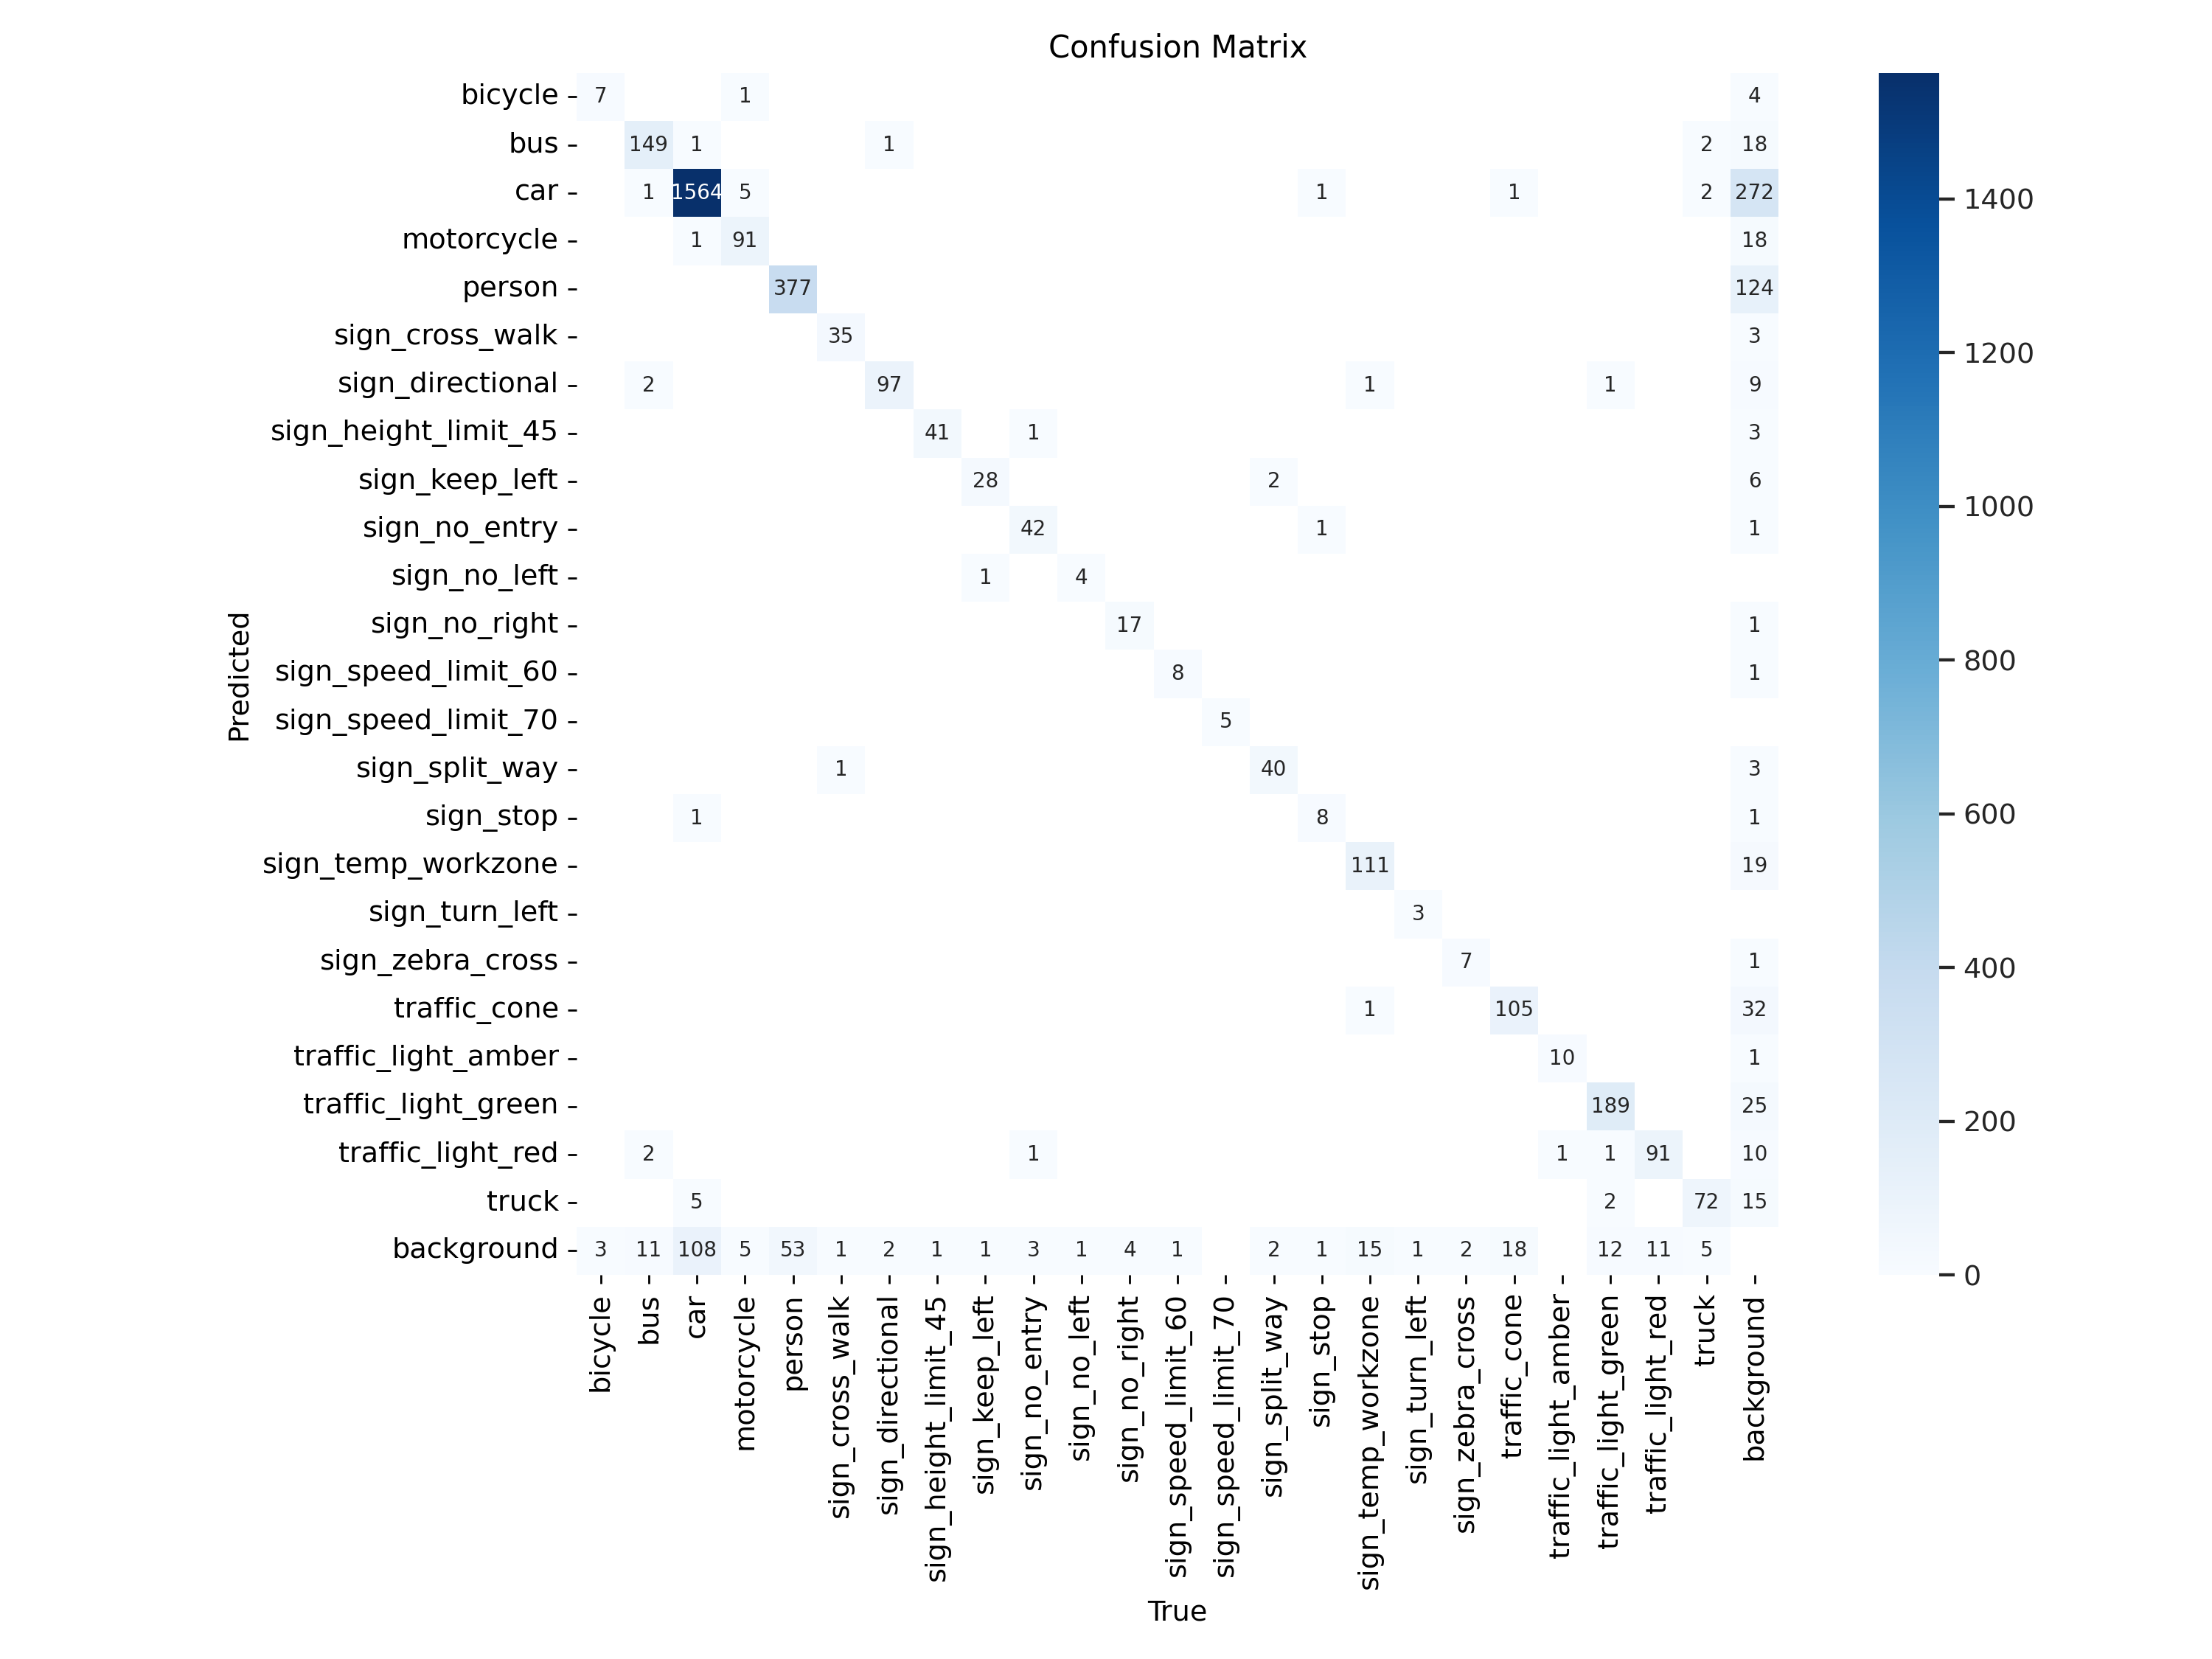

In [8]:
Image(filename="/content/runs/detect/train/confusion_matrix.png", width=720)

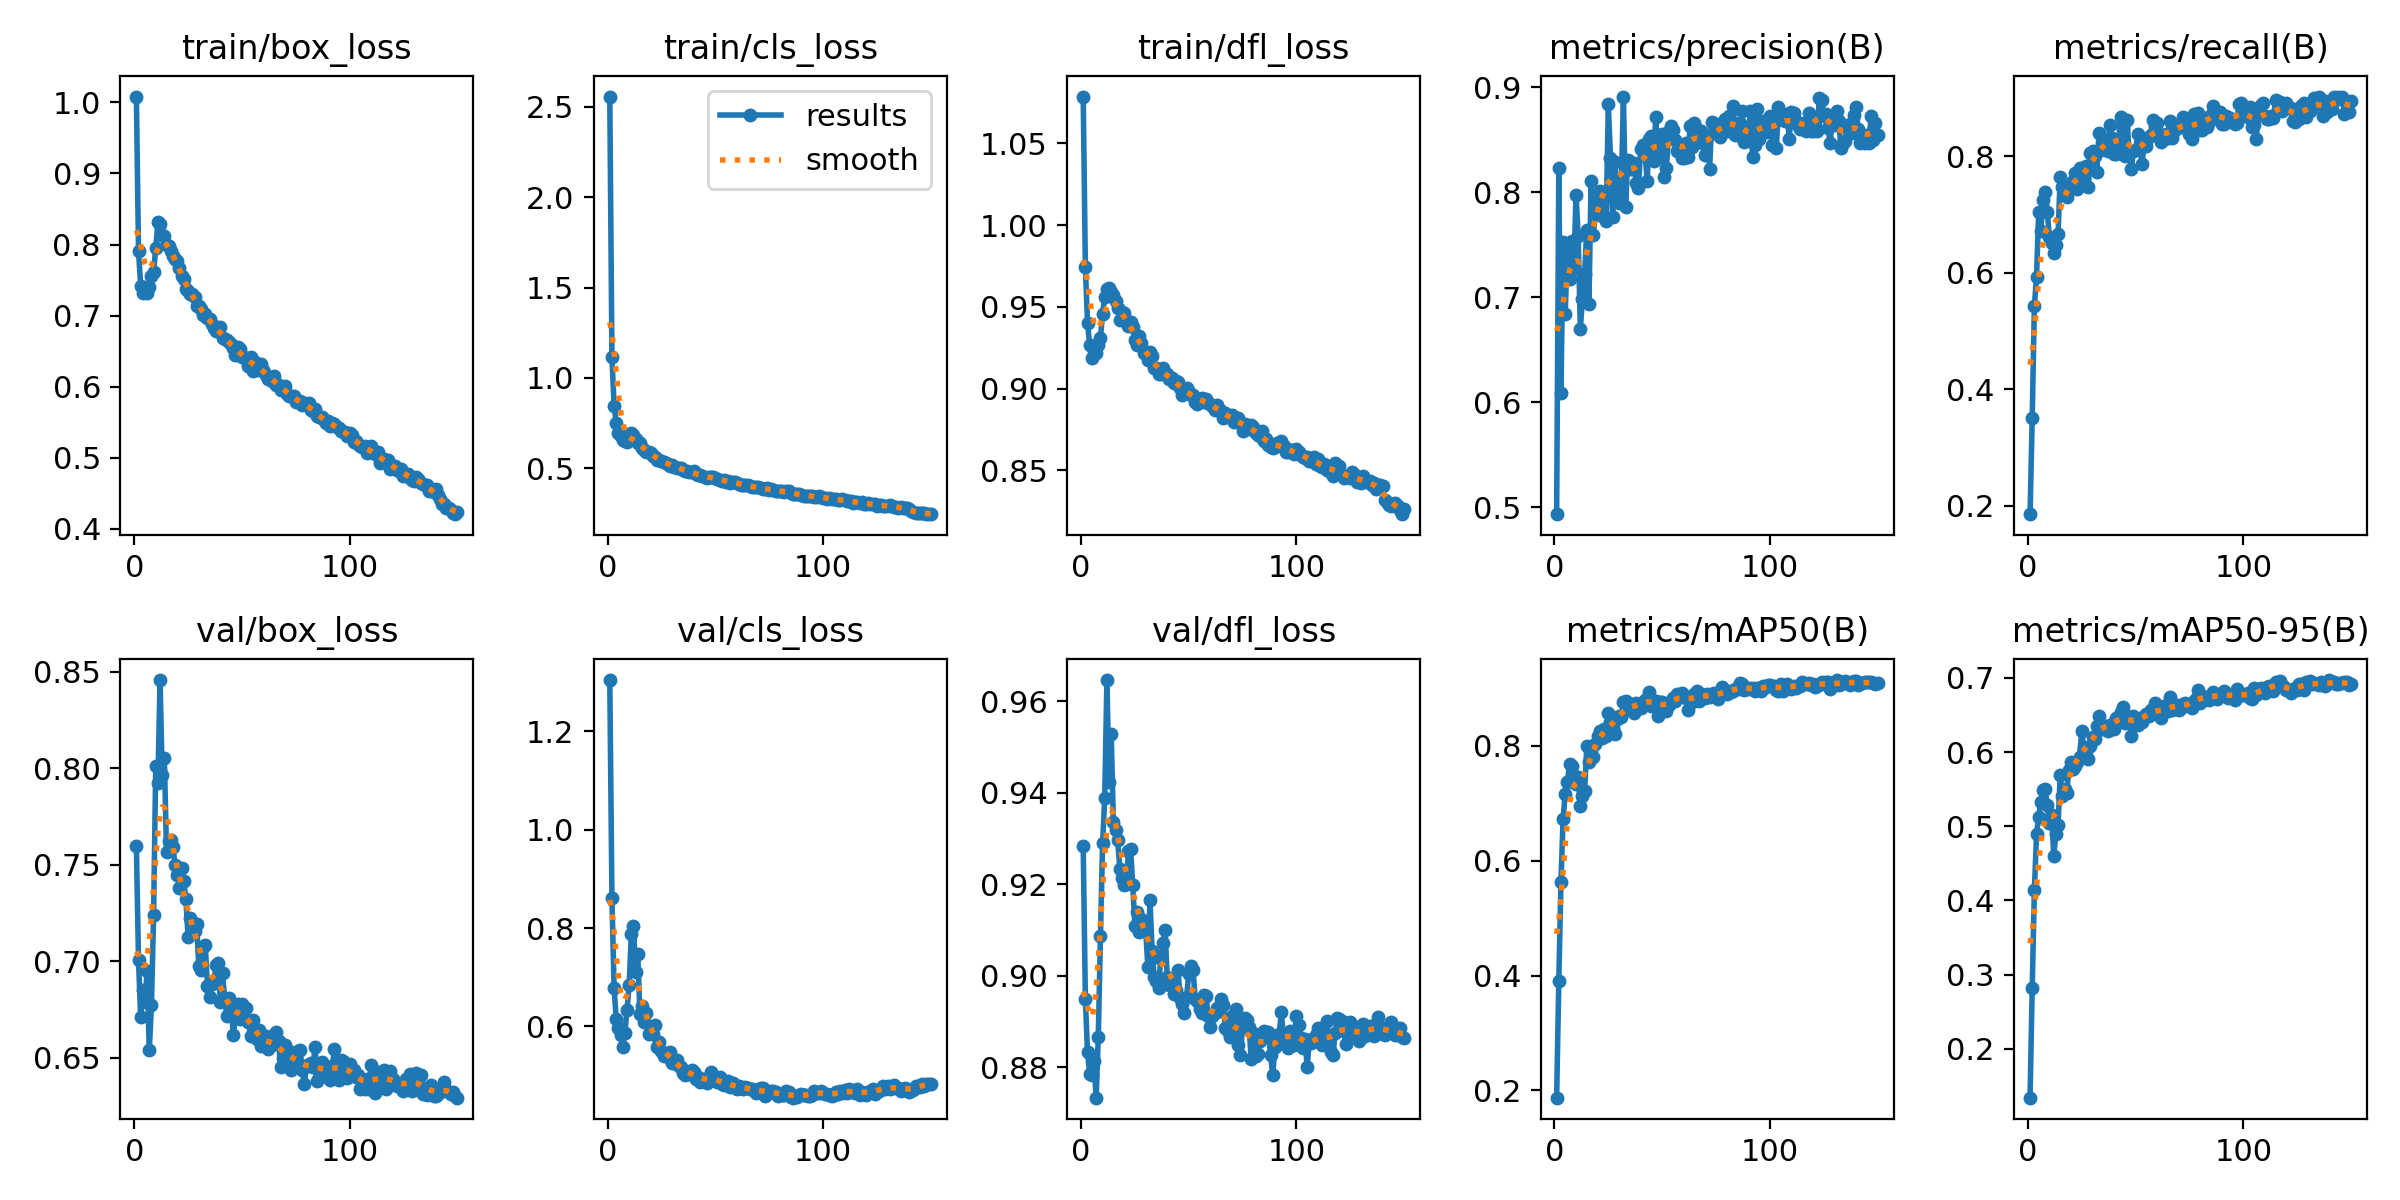

In [9]:
Image(filename="/content/runs/detect/train/results.png", width=720)

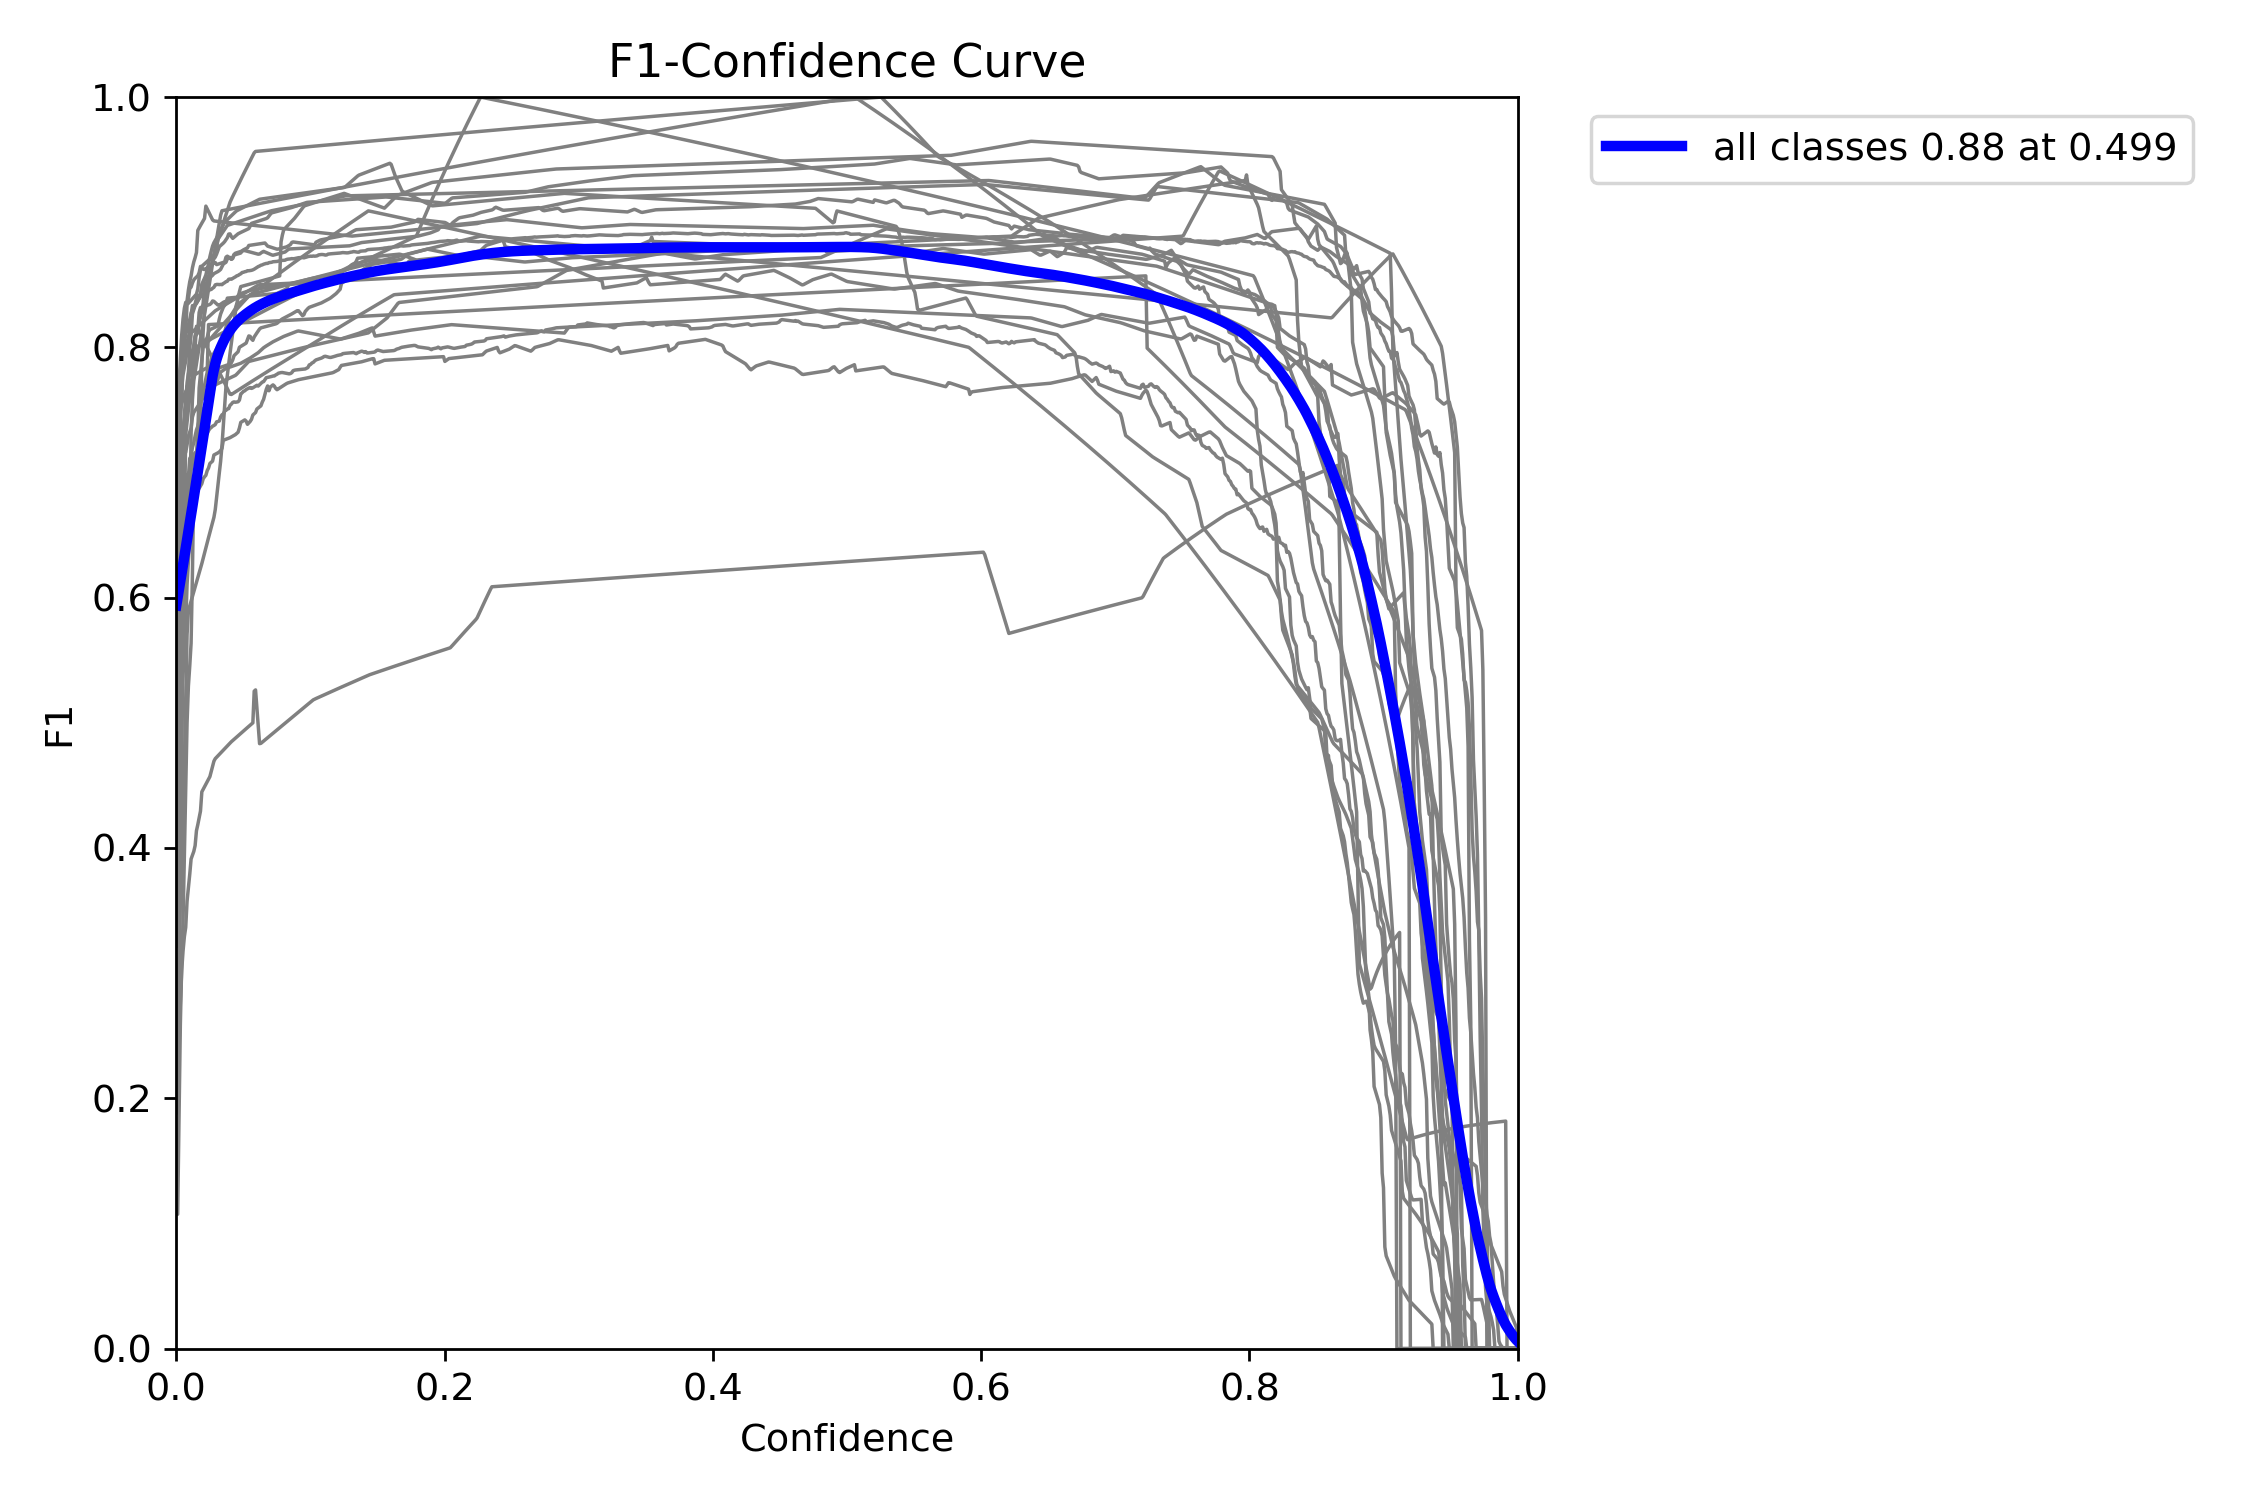

In [10]:
Image(filename="/content/runs/detect/train/F1_curve.png", width=600)

In [11]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

In [12]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25853656 parameters, 0 gradients, 78.8 GFLOPs


val: Scanning /content/singapore_road_objects_v2-3/valid/labels.cache... 381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 381/381 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]


                   all        381       3402      0.881      0.881      0.914        0.7
               bicycle        381         10      0.568        0.7      0.633      0.338
                   bus        381        165      0.888      0.903      0.938      0.886
                   car        381       1680      0.869      0.913      0.943      0.863
            motorcycle        381        102      0.867      0.893      0.924       0.72
                person        381        430      0.801      0.833      0.863      0.594
       sign_cross_walk        381         37      0.915      0.946      0.962      0.768
      sign_directional        381        100      0.919       0.97      0.965      0.824
  sign_height_limit_45        381         42      0.925      0.976      0.965      0.791
        sign_keep_left        381         30      0.834      0.933       0.93      0.701
         sign_no_entry        381         47      0.953      0.872      0.959      0.606
          sign_no_lef

Use this code below to zip the model folder for downloading

In [13]:
# zip runs folder
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/P_curve.png (deflated 11%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/last.pt (deflated 8%)
  adding: content/runs/detect/train/weights/best.pt (deflated 8%)
  adding: content/runs/detect/train/train_batch8400.jpg (deflated 3%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 5%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 5%)
  adding: content/runs/detect/train/train_batch8401.jpg (deflated 5%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 32%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 1%)
  adding: content/runs/detect/train/PR_curve.png (deflated 13%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 14%)
  adding: content/runs/detect/train/events.out.tfe

---

## 5. Inference Code
Below are the codes to do inference.
Please adjust the paths to your model file and your test file.
In this example I use google drive, since I run rhis notebook using google colab.

In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 5.1 Inference Using CLI

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt conf=0.35 source=/content/drive/MyDrive/capstone_1/driving_shorter.mp4

### 5.2 Inference Using Python

In [1]:
from ultralytics import YOLO
# Load model
model = YOLO('../model/runs/detect/train/weights/best.pt')

In [4]:
import cv2
results = model(source='../datasets/videos/test_3.mp4', show=True, conf=0.2, save=True)

cv2.destroyAllWindows()



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 6 cars, 2 persons, 1 sign_cross_walk, 1 sign_no_entry, 1 traffic_light_green, 1 truck, 314.2ms
video 1/1 (frame 2/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 6 cars, 2 persons, 1 sign_cross_walk, 1 sign_no_entry, 1 traffic_light_green, 1 truck, 267.3ms
video 1/1 (frame 3/180) C:\Users\MichaelKS\GA\person

video 1/1 (frame 41/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 8 cars, 3 persons, 2 sign_cross_walks, 1 sign_no_entry, 1 traffic_light_green, 362.7ms
video 1/1 (frame 42/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 7 cars, 3 persons, 2 sign_cross_walks, 2 sign_no_entrys, 1 traffic_light_green, 240.0ms
video 1/1 (frame 43/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 7 cars, 4 persons, 2 sign_cross_walks, 2 sign_no_entrys, 1 traffic_light_green, 263.4ms
video 1/1 (frame 44/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 7 cars, 4 persons, 2 sign_cross_walks, 2 sign_no_entrys, 1 traffic_light_green, 255.2ms
video 1/1 (frame 45/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 7 cars, 2 persons, 2 sign_cross_walks, 2 sign_no_entrys, 1 traffic_light_gre

video 1/1 (frame 84/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 6 cars, 7 persons, 1 sign_cross_walk, 1 sign_no_entry, 1 traffic_light_green, 291.4ms
video 1/1 (frame 85/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 6 cars, 5 persons, 2 sign_cross_walks, 1 sign_no_entry, 1 traffic_light_green, 276.6ms
video 1/1 (frame 86/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 7 cars, 4 persons, 2 sign_cross_walks, 1 sign_no_entry, 1 traffic_light_green, 288.1ms
video 1/1 (frame 87/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 6 cars, 1 motorcycle, 5 persons, 2 sign_cross_walks, 1 sign_no_entry, 1 traffic_light_green, 274.0ms
video 1/1 (frame 88/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 1 bus, 7 cars, 1 motorcycle, 4 persons, 2 sign_cross_walks, 1 sign_no_entry, 1 traffic_

video 1/1 (frame 125/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 3 cars, 1 motorcycle, 10 persons, 1 sign_cross_walk, 1 traffic_light_green, 268.8ms
video 1/1 (frame 126/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 3 cars, 1 motorcycle, 8 persons, 1 sign_cross_walk, 2 traffic_light_greens, 299.5ms
video 1/1 (frame 127/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 1 motorcycle, 8 persons, 1 sign_cross_walk, 1 sign_no_entry, 2 traffic_light_greens, 272.2ms
video 1/1 (frame 128/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 1 motorcycle, 9 persons, 1 sign_cross_walk, 1 sign_no_entry, 2 traffic_light_greens, 267.6ms
video 1/1 (frame 129/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 3 cars, 1 motorcycle, 8 persons, 1 sign_cross_walk, 1 sign_no_entry, 2 traffic_l

video 1/1 (frame 168/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 2 motorcycles, 5 persons, 316.7ms
video 1/1 (frame 169/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 2 motorcycles, 4 persons, 282.3ms
video 1/1 (frame 170/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 2 motorcycles, 5 persons, 274.5ms
video 1/1 (frame 171/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 2 motorcycles, 5 persons, 348.1ms
video 1/1 (frame 172/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 4 cars, 2 motorcycles, 5 persons, 459.4ms
video 1/1 (frame 173/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\videos\test_3.mp4: 416x736 5 cars, 2 motorcycles, 6 persons, 349.5ms
video 1/1 (frame 174/180) C:\Users\MichaelKS\GA\personal\capstone\code\..\datasets\video

### 5.3 Inference and show the frame rate

In [15]:
import cv2
import random
import time
import os
from ultralytics import YOLO

def get_name(file_path):
  name_idx = 0
  file_pos = (file_path).rfind('\\')

  if(file_pos == -1):
      file_pos = (file_path).rfind('/')

      if(file_pos == -1):
          file_pos = 0

  name_idx = file_pos + 1

  name = file_path[name_idx:]

  return name

def get_save_path(file_name, folder_name):
  path = "result"
  save_path = os.path.join(path, folder_name)

  exists = os.path.exists(save_path)

  if(not exists):
      os.makedirs(save_path)

  save_path = os.path.join(save_path, file_name)

  return save_path

def draw_box(img, detection_results, class_list, colors, label_size) :
  # Get information from result
  xyxy = detection_results.boxes.xyxy.numpy()
  confidence = detection_results.boxes.conf.numpy()
  class_ids = detection_results.boxes.cls.numpy().astype(int)
  # Pack together for easy use
  results = list(zip(class_ids, confidence, xyxy))
  # Copy image, in case that we need original image for something
  out_image = img.copy()

  for result in results :
    # Unpack
    class_id, con, box = result
    # Choose color
    box_color = colors[int(class_id)]
    text_color = (255,255,255)
    # Get Class Name
    label = class_list[int(class_id)]
    # Draw object box
    first_half_box = (int(box[0]),int(box[1]))
    second_half_box = (int(box[2]),int(box[3]))
    cv2.rectangle(out_image, first_half_box, second_half_box, box_color, 2)

    # Create text
    text_print = '{label} {con:.2f}'.format(label = label, con = con)
    # Locate text position
    text_location = (int(box[0]), int(box[1] - 10 ))
    # Get size and baseline
    labelSize, baseLine = cv2.getTextSize(text_print, cv2.FONT_HERSHEY_SIMPLEX, label_size, 1)

    # Draw text's background
    cv2.rectangle(out_image
                    , (int(box[0]), int(box[1] - labelSize[1] - 10 ))
                    , (int(box[0])+labelSize[0], int(box[1] + baseLine-10))
                    , box_color , cv2.FILLED)
    # Put text
    cv2.putText(out_image, text_print ,text_location
                , cv2.FONT_HERSHEY_SIMPLEX , label_size
                , text_color, 2, cv2.LINE_AA)

  return out_image

def draw_fps(avg_fps, img):
  avg_fps_str = float("{:.2f}".format(avg_fps))

  cv2.rectangle(img, (10,2), (280,50), (255,255,255), -1)
  cv2.putText(img, "FPS: "+str(avg_fps_str), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), thickness=3)

  return img

In [16]:
def detection(source, model, folder_name, img_size, label_size=1):
  # Initialize video
  cap = cv2.VideoCapture(source)

  # Initialize YOLOv8 model
  model_path = model
  yolov8_detector = YOLO(model_path)

  # Class Name and Colors
  label_map = yolov8_detector.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in label_map]

  # FPS Detection
  frame_count = 0
  total_fps = 0
  avg_fps = 0

  # FPS Video
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))

  video_frames = []

  while cap.isOpened():
    # Press key q to stop
    if cv2.waitKey(1) == ord('q'):
        break

    try:
        # Read frame from the video
        ret, frame = cap.read()
        if not ret:
            break
    except Exception as e:
        print(e)
        continue

    # # Start Time
    start = time.time()
    # Update object localizer
    results = yolov8_detector.predict(frame, imgsz=img_size, verbose=False)
    result = results[0].cpu()

    # Draw Detection Results
    combined_img = draw_box(frame, result, label_map, colors, label_size)

    end = time.time()
    # # End Time

    # Draw FPS
    frame_count += 1
    fps = 1 / (end - start)
    total_fps = total_fps + fps
    avg_fps = total_fps / frame_count

    combined_img = draw_fps(avg_fps, combined_img)

    # Append frame to array
    video_frames.append(combined_img)

    #
    print("(%2d / %2d) Frames Processed" % (frame_count, total_frames))

  print("\nCreate a Video:")

  # Get a file name
  file_name = get_name(source)
  # Get Save Path
  save_path = get_save_path(file_name, folder_name)
  # Create VideoWriter object.
  out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'XVID'), int(avg_fps), (frame_width, frame_height))

  for frame in video_frames:
    out.write(frame)

  out.release()

  print("Video is saved in: "+save_path)

I ran the code below in Google Colab to test the inference frame rate.  
I achieved around 60 frames per second using Google Colab's L4 GPU. In contrast, running it locally on my GPU yielded only about 5 frames per second.

In [19]:
# Inference with frame rate
detection('/content/drive/MyDrive/capstone/datasets/videos/test.mp4', '/content/runs/detect/train/weights/best.pt', "predict", 736)

( 1 / 150) Frames Processed
( 2 / 150) Frames Processed
( 3 / 150) Frames Processed
( 4 / 150) Frames Processed
( 5 / 150) Frames Processed
( 6 / 150) Frames Processed
( 7 / 150) Frames Processed
( 8 / 150) Frames Processed
( 9 / 150) Frames Processed
(10 / 150) Frames Processed
(11 / 150) Frames Processed
(12 / 150) Frames Processed
(13 / 150) Frames Processed
(14 / 150) Frames Processed
(15 / 150) Frames Processed
(16 / 150) Frames Processed
(17 / 150) Frames Processed
(18 / 150) Frames Processed
(19 / 150) Frames Processed
(20 / 150) Frames Processed
(21 / 150) Frames Processed
(22 / 150) Frames Processed
(23 / 150) Frames Processed
(24 / 150) Frames Processed
(25 / 150) Frames Processed
(26 / 150) Frames Processed
(27 / 150) Frames Processed
(28 / 150) Frames Processed
(29 / 150) Frames Processed
(30 / 150) Frames Processed
(31 / 150) Frames Processed
(32 / 150) Frames Processed
(33 / 150) Frames Processed
(34 / 150) Frames Processed
(35 / 150) Frames Processed
(36 / 150) Frames Pr

## 6. Models Comparison

![alt text](../images/notebook/modelHyperparameters.JPG)

![alt text](../images/notebook/modelMetrics.JPG)

Model 5, using the m-sized architecture with the SGD optimizer, is my best model.
Even though it's the most expensive model, it has the highest precision, recall, mAP50, and mAP50-95, which are important for accurately detecting objects.

---

## 7. Demonstration of Pixel Pilot Kit Predictions

Click the link or image below to play the video.  
https://youtu.be/0kWsk-mPD_4
[![Watch the video](https://img.youtube.com/vi/0kWsk-mPD_4/maxresdefault.jpg)](https://youtu.be/0kWsk-mPD_4)

![alt text](../images/notebook/inferencecombine.JPG)  
The model is able to detect changes in traffic lights, traffic cones, people, different types of vehicles, and road signs.

---

## 8. Demonstration of Pixel Pilot Kit Frame Rate

Click the link or image below to play the video.  
https://youtu.be/Y-IhF9gIvvM
[![Watch the video](https://img.youtube.com/vi/Y-IhF9gIvvM/maxresdefault.jpg)](https://youtu.be/Y-IhF9gIvvM)
Our model is running at around 60 frame per second, which is good to run real time.

---

## 9. Conclusion

In conclusion, to accurately identify various obstacles, such as pedestrians, other vehicles, road signs, and objects, to enhance safety and navigation in self-driving cars in Singapore, we can leverage our trained model that specializes in detecting Singapore road obstacles and traffic signs and lights.

---

## 10. Limitations and Recommendations

- **Limitation :**
  - Imbalanced data might cause the model to miss the minority classes or predict with much lower confidence score, leading to lower recall and precision for those classes.

- **Recommendations :**
  - adjust loss weight which can help to address the issue of imbalanced data
  - Gather additional data for under-represented class.
---

- **Limitation :**
  - The existing dataset contains only daytime data and has less than 20 traffic signs.

- **Recommendations :**
  - Expand the dataset, there are other signs and objects that are not currently included. We also need to include vehicle brake lights so we can anticipate them.
  - Collect night time data and use data augmentation to build a model that's robust across different times of day and weather conditions.
---

- **Other Recommendation :**
  - Run gridsearch to get best parameters.
  - Test to use tiling windows to detect further or small objects. Divide image into a few smaller tiles, then perform inference on each individual tile. It’s slower but more effective at detecting small objects. This is important, so the model can detect traffic signs or objects from far to anticipate them.
  ![alt text](../images/notebook/tilingwindow.JPG)
  - Test to use TensorRT to improve inference time/ frame rate.